# Random Forest Modelling Notebook for DEFRA - All Targets (37 Pollutants)

This notebook trains Random Forest models for all site_pollutant combinations in the DEFRA network, including regulatory pollutants, nitrogen species, and VOCs.

**Input:** `data/defra/ml_prep_all_37` folder  
**Output:** `data/defra/rf_model_all_37` folder  
**Reference:** Geron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition, heavy usage of scikit-learn documentation.

---

## What this notebook does

1. Load prepared data from ml_prep_all_37 output.
2. Identify all pollution targets (95 site_pollutant combinations across 37 pollutant types).
3. Tune hyperparameters per pollutant category (12 tuning runs).
4. Train a Random Forest model for each target with progress tracking.
5. Evaluate using RMSE, MAE, r2 for all models.
6. Analyse results by pollutant category.
7. Save all trained models.

---

## Why 37 pollutants?

DEFRA's AURN network monitors additional pollutants beyond the six regulatory ones used in the baseline comparison. This expanded dataset tests whether the Random Forest approach generalises to different pollutant types with varying chemical behaviours.

### Pollutant categories

- **Regulatory (6):** NO2, PM2.5, PM10, O3, SO2, CO. These are the main pollutants with UK legal limits.
- **Nitrogen species (2):** NO, NOx. Related to traffic emissions but not directly regulated.
- **Aromatic VOCs (~8):** Benzene, Toluene, Xylenes, Trimethylbenzenes. From vehicle exhaust and industrial sources.
- **Alkanes (~10):** Ethane, Propane, Butanes, Pentanes. Lighter hydrocarbons from fuel evaporation.
- **Alkenes (~8):** Ethene, Propene, Butenes, Butadiene. Reactive compounds important for ozone formation.
- **Other VOCs (~3):** Ethyne, Methylpentanes. Miscellaneous volatile compounds.

---

## Training approach

Instead of using GridSearchCV or MultiOutputRegressor which trains all 95 targets simultaneously, I train each site_pollutant combination separately. This allows progress tracking, individual model evaluation, and saving intermediate results.

**Targets:** 37 pollutant types across 95 site_pollutant combinations.

- NO2: 13 sites.
- Nitrogen (NO, NOx): 26 sites.
- O3: 8 sites.
- PM10: 7 sites.
- PM25: 7 sites.
- SO2: 3 sites.
- CO: 2 sites.
- Aromatic VOCs: 3 sites.
- Alkanes: 2 sites.
- Alkenes: 3 sites.
- Other VOCs: 1 site.
- Unknown (unclassified): 20 sites.

---

## Dataset comparison

| Metric | DEFRA 6 Pollutants | DEFRA 37 Pollutants |
|--------|-------------------|--------------------|
| Site-pollutant combinations | 40 | 95 |
| Training samples | 17,036 | 17,036 |
| Flattened features | 528 | 1,188 |
| Original features | 44 | 99 |
| Pollutant categories | 6 | 12 |

The 37 pollutant dataset has 2.25x more features due to the additional VOC measurements, but the same sample count. This tests whether the model can handle increased dimensionality while maintaining accuracy.

---

## Development history

This notebook applies the same approach validated in the 6 pollutant training.

**Applied from 6 pollutant experience:**

- Used HalvingGridSearchCV from the start.
- Tuned one representative site per pollutant category (12 tuning runs).
- Applied optimal params to all sites of that category.
- Checkpoint saving every 20 models for safety.
- Memory-safe parameters (max_depth capped at 15, n_estimators at 100).
- Ran tuning on Google Colab, training on local machine.

**Training times:**

- Tuning: approximately 438 minutes total (Colab).
- Full training: approximately 937 minutes estimated (95 models vs 40).

In [ ]:
#Imports as usual at the top.
import numpy as np
import pandas as pd
import joblib
import gc
import time
from pathlib import Path
from datetime import datetime

#Section 8 investigate broken models imports.
from collections import Counter

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import matplotlib.pyplot as plt

In [2]:
#Paths as second, the folders for loading and saving the results.
base_dir = Path.cwd().parent.parent / "data" / "defra"
ml_prep_dir = base_dir / "ml_prep_all_37"
rf_output_dir = base_dir / "rf_model_all_37"
rf_output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = rf_output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading from: {ml_prep_dir}")
print(f"Saving to: {rf_output_dir}")

Loading from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all_37
Saving to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all_37


## 1) Load prepared data

The ml_prep_all_37 notebook created:
- `X_train_rf.npy`: Flattened training features (17,036 samples x 1,188 features).
- `X_val_rf.npy`: Flattened validation features.
- `X_test_rf.npy`: Flattened test features.
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values (99 features each).
- `rf_feature_names.joblib`: Feature names for interpretability.
- `scaler.joblib`: MinMaxScaler to reverse normalisation.

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, 12 timesteps, 99 features).

12 x 99 = 1,188 flattened features per sample.

In [3]:
#load ml_prep37 data to train and avaluate 
X_train_rf = np.load(ml_prep_dir / "X_train_rf.npy")
X_val_rf = np.load(ml_prep_dir / "X_val_rf.npy")
X_test_rf = np.load(ml_prep_dir / "X_test_rf.npy")
y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")
feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")
try:
    rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
except:
    rf_feature_names = [f"feature_{i}" for i in range(X_train_rf.shape[1])]

print(f"X_train_rf: {X_train_rf.shape}")
print(f"y_train: {y_train.shape}")
print(f"Features: {len(feature_names)}")

Loading data...
X_train_rf: (17036, 1188)
y_train: (17036, 99)
Features: 99


### DEFRA 6 vs 37 Pollutant Comparison

| Metric             | DEFRA 6   | DEFRA 37  |
| ------------------ | --------- | --------- |
| Training samples   | 17,036    | 17,036    |
| Original features  | 44        | 99        |
| Timesteps          | 12        | 12        |
| Flattened features | 528       | 1,188     |
| Target features    | 44        | 99        |

## 2) Identify pollution targets

The y array has 99 columns. Looking at feature_names, the last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 95 columns are site_pollutant combinations. These are categorised into groups for tuning:

- **Regulatory (6):** NO2, PM2.5, PM10, O3, SO2, CO.
- **Nitrogen (2):** NO, NOx.
- **Aromatic VOCs:** Benzene, Toluene, Ethylbenzene, Xylenes, Trimethylbenzenes.
- **Alkanes:** Ethane, Propane, Butanes, Pentanes, Hexanes, Heptane, Octane.
- **Alkenes:** Ethene, Propene, Butenes, Butadiene, Isoprene, Pentene.
- **Other VOCs:** Ethyne, Methylpentanes.

In [4]:
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

#37 defra pollutants organised by category
REGULATORY = ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']
NITROGEN = ['NO', 'NOx']
AROMATIC_VOCS = ['Benzene', 'Toluene', 'Ethylbenzene', 'm-Xylene', 'p-Xylene', 'o-Xylene', '1,2,4-Trimethylbenzene', '1,3,5-Trimethylbenzene']
ALKANES = ['Ethane', 'Propane', 'i-Butane', 'n-Butane', 'i-Pentane', 'n-Pentane', 'n-Hexane', 'n-Heptane', 'n-Octane', '2,2,4-Trimethylpentane']
ALKENES = ['Ethene', 'Propene', '1-Butene', 'cis-2-Butene', 'trans-2-Butene', '1,3-Butadiene', 'Isoprene', '1-Pentene']
OTHER_VOCS = ['Ethyne', '2-Methylpentane', '3-Methylpentane']

def get_pollutant_category(name):
    """Categorise pollutant for tuning groups."""
    #Check regulatory first
    for poll in REGULATORY:
        if poll in name:
            return poll
    #Nitrogen species but not NO2, cuz it is under regulatory
    for poll in NITROGEN:
        if poll in name and 'NO2' not in name:
            return 'Nitrogen'
    #Aromatic VOCs
    for poll in AROMATIC_VOCS:
        if poll in name:
            return 'Aromatic_VOC'
    #Alkanes
    for poll in ALKANES:
        if poll in name:
            return 'Alkane'
    #Alkenes
    for poll in ALKENES:
        if poll in name:
            return 'Alkene'
    #Other VOCs
    for poll in OTHER_VOCS:
        if poll in name:
            return 'Other_VOC'
    return 'Unknown'

pollution_targets = []
target_mapping = {}
targets_by_category = {}

for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        pollution_targets.append(name)
        target_mapping[name] = i
        category = get_pollutant_category(name)
        if category not in targets_by_category:
            targets_by_category[category] = []
        targets_by_category[category].append(name)

print(f"Total pollution targets: {len(pollution_targets)}")
print("\nTargets by category:")
for cat, targets in sorted(targets_by_category.items()):
    print(f"  {cat}: {len(targets)} targets")
    for t in targets[:3]:  # show first 3
        print(f"    - {t}")
    if len(targets) > 3:
        print(f"    ... and {len(targets)-3} more")

Total pollution targets: 95

Targets by category:
  Alkane: 2 targets
    - London_Marylebone_Road_Ethane
    - London_Marylebone_Road_Propane
  Alkene: 3 targets
    - London_Marylebone_Road_Ethene
    - London_Marylebone_Road_Isoprene
    - London_Marylebone_Road_Propene
  Aromatic_VOC: 3 targets
    - London_Marylebone_Road_Benzene
    - London_Marylebone_Road_Ethylbenzene
    - London_Marylebone_Road_Toluene
  CO: 2 targets
    - London_Marylebone_Road_CO
    - London_N._Kensington_CO
  NO2: 13 targets
    - Borehamwood_Meadow_Park_NO2
    - Camden_Kerbside_NO2
    - Haringey_Roadside_NO2
    ... and 10 more
  Nitrogen: 26 targets
    - Borehamwood_Meadow_Park_NO
    - Borehamwood_Meadow_Park_NOx
    - Camden_Kerbside_NO
    ... and 23 more
  O3: 8 targets
    - London_Bloomsbury_O3
    - London_Haringey_Priory_Park_South_O3
    - London_Harlington_O3
    ... and 5 more
  Other_VOC: 1 targets
    - London_Marylebone_Road_Ethyne
  PM10: 7 targets
    - Borehamwood_Meadow_Park_PM10
 

    Total pollution targets: 95

    Targets by category:
    Alkane: 2 targets
        - London_Marylebone_Road_Ethane
        - London_Marylebone_Road_Propane
    Alkene: 3 targets
        - London_Marylebone_Road_Ethene
        - London_Marylebone_Road_Isoprene
        - London_Marylebone_Road_Propene
    Aromatic_VOC: 3 targets
        - London_Marylebone_Road_Benzene
        - London_Marylebone_Road_Ethylbenzene
        - London_Marylebone_Road_Toluene
    CO: 2 targets
        - London_Marylebone_Road_CO
        - London_N._Kensington_CO
    NO2: 13 targets
        - Borehamwood_Meadow_Park_NO2
        - Camden_Kerbside_NO2
        - Haringey_Roadside_NO2
        ... and 10 more
    Nitrogen: 26 targets
        - Borehamwood_Meadow_Park_NO
        - Borehamwood_Meadow_Park_NOx
        - Camden_Kerbside_NO
        ... and 23 more
    O3: 8 targets
        - London_Bloomsbury_O3
        - London_Haringey_Priory_Park_South_O3
        - London_Harlington_O3
        ... and 5 more
    Other_VOC: 1 targets
        - London_Marylebone_Road_Ethyne
    PM10: 7 targets
        - Borehamwood_Meadow_Park_PM10
        - London_Bexley_PM10
        - London_Bloomsbury_PM10
        ... and 4 more
    PM25: 7 targets
        - Borehamwood_Meadow_Park_PM25
        - London_Bloomsbury_PM25
        - London_Harlington_PM25
        ... and 4 more
    SO2: 3 targets
        - London_Bloomsbury_SO2
        - London_Marylebone_Road_SO2
        - London_N._Kensington_SO2
    Unknown: 20 targets
        - London_Marylebone_Road_1_2_3_TMB
        - London_Marylebone_Road_1_2_4_TMB
        - London_Marylebone_Road_1_3_5_TMB
        ... and 17 more

## 3) Hyperparameter tuning per pollutant category

Rather than tuning all 95 models individually with GridSearchCV (which was inefficient), I tune separately for each pollutant category using HalvingGridSearchCV.

### Why HalvingGridSearchCV instead of GridSearchCV?

From scikit-learn documentation:
> "Successive Halving is an iterative selection process. The first iteration is run with a small amount of resources. Only some candidates are selected to go on to the next iteration, which will be allocated more resources."

This is more efficient than exhaustive GridSearchCV because it eliminates poor parameter combinations early.

### Tuning strategy

For each pollutant category:
1. Select one representative site (the first alphabetically for consistency).
2. Run HalvingGridSearchCV to find optimal params.
3. Store those params to use for all sites measuring that pollutant type.

This gives 12 tuning runs instead of 95, balancing accuracy and efficiency.

### Key hyperparameters to tune for Random Forest

| Parameter | Description | Effect |
|-----------|-------------|--------|
| n_estimators | Number of trees. | More trees = better accuracy but slower. |
| max_depth | Maximum tree depth. | Limits complexity, prevents overfitting. |
| min_samples_split | Minimum samples to split node. | Higher = simpler trees. |
| min_samples_leaf | Minimum samples in leaf. | Higher = smoother predictions. |

Source: scikit-learn (no date) *sklearn.ensemble.RandomForestRegressor*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [5]:
# # Representative targets (first alphabetically per category)
# representative_targets = {}
# for category, targets in targets_by_category.items():
#     if category != 'Unknown' and len(targets) > 0:
#         representative_targets[category] = sorted(targets)[0]

# print(f"Categories to tune: {len(representative_targets)}")
# print("\nRepresentative targets for tuning:")
# for cat, target in sorted(representative_targets.items()):
#     print(f"  {cat}: {target}")

# # Parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
# print(f"\nParameter grid: 24 combinations")

In [6]:
# print("Hyperparameter tuning per pollutant type")
# print("=" * 60)

# best_params_by_pollutant = {}
# tuning_results = []
# total_tuning_start = time.time()

# for i, (pollutant, target_name) in enumerate(sorted(representative_targets.items())):
#     target_idx = target_mapping[target_name]
#     print(f"\n[{i+1}/{len(representative_targets)}] Tuning {pollutant} using {target_name}")
    
#     tuning_start = time.time()
#     rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
#     halving_search = HalvingGridSearchCV(
#         rf, param_grid, cv=3, scoring='r2', factor=2,
#         min_resources='smallest', aggressive_elimination=False,
#         n_jobs=-1, verbose=1, random_state=42
#     )
#     halving_search.fit(X_train_rf, y_train[:, target_idx])
    
#     tuning_time = time.time() - tuning_start
#     best_params_by_pollutant[pollutant] = halving_search.best_params_
    
#     tuning_results.append({
#         'pollutant': pollutant, 'target': target_name,
#         'best_score': halving_search.best_score_, 'time': tuning_time,
#         **halving_search.best_params_
#     })
    
#     print(f"Best CV R2: {halving_search.best_score_:.4f}, Time: {tuning_time/60:.1f}min")
#     del halving_search; gc.collect()

# total_tuning_time = time.time() - total_tuning_start
# print(f"\nTotal tuning time: {total_tuning_time/60:.1f} minutes")

### Tuning results summary

| Category | Best CV r2 | Time (min) | n_estimators | max_depth | min_samples_split | min_samples_leaf |
|----------|-----------|------------|--------------|-----------|-------------------|------------------|
| Alkane | 0.2400 | 70.7 | 200 | 20 | 2 | 1 |
| Alkene | 0.5784 | 37.6 | 200 | 10 | 2 | 1 |
| Aromatic_VOC | 0.3355 | 34.3 | 200 | 10 | 5 | 1 |
| CO | 0.6849 | 37.3 | 200 | 10 | 2 | 2 |
| NO2 | 0.6960 | 37.5 | 200 | 10 | 5 | 1 |
| Nitrogen | 0.6971 | 35.0 | 200 | 10 | 5 | 1 |
| O3 | 0.8415 | 19.0 | 100 | 10 | 5 | 2 |
| Other_VOC | 0.3798 | 36.3 | 200 | 10 | 5 | 2 |
| PM10 | 0.6436 | 37.2 | 200 | 10 | 5 | 2 |
| PM25 | 0.6320 | 37.0 | 200 | 10 | 5 | 1 |
| SO2 | 0.8924 | 36.7 | 200 | 10 | 5 | 2 |

**Total tuning time:** approximately 438 minutes (7.3 hours on Colab).

**Key observations:**

- O3 and SO2 show highest CV r2 (0.84-0.89), consistent with 6 pollutant results.
- VOCs show lower CV r2 (0.24-0.58), as expected from their more complex behaviour.
- max_depth of 10 works for most categories, only Alkanes needed deeper trees (20).

In [17]:
# Tuning results from  Colab run Document 1
best_params_by_pollutant = {
    'Alkane': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    'Alkene': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    'Aromatic_VOC': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    'CO': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200},
    'NO2': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    'Nitrogen': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    'O3': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100},
    'Other_VOC': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200},
    'PM10': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200},
    'PM25': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    'SO2': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200},
    'Unknown': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}  # default for Unknown category
}

# Memory-safe version educe n_estimators for local
best_params_memory_safe = {k: {**v, 'n_estimators': 100} for k, v in best_params_by_pollutant.items()}

print("Tuning parameters loaded from previous Colab run!")
print("Skipping tuning phase proceeding directly to training...")

Tuning parameters loaded from previous Colab run!
Skipping tuning phase proceeding directly to training...


In [8]:
# Save tuning results summary
tuning_data = {
    'pollutant': ['Alkane', 'Alkene', 'Aromatic_VOC', 'CO', 'NO2', 
                  'Nitrogen', 'O3', 'Other_VOC', 'PM10', 'PM25', 'SO2'],
    'best_score': [0.2400, 0.5784, 0.3355, 0.6849, 0.6960,
                   0.6971, 0.8415, 0.3798, 0.6436, 0.6320, 0.8924],
    'time_min': [70.7, 37.6, 34.3, 37.3, 37.5,
                 35.0, 19.0, 36.3, 37.2, 37.0, 36.7]
}
tuning_df = pd.DataFrame(tuning_data)

tuning_df.to_csv(rf_output_dir / 'tuning_results_by_pollutant.csv', index=False)
joblib.dump(best_params_by_pollutant, rf_output_dir / 'best_params_by_pollutant.joblib')

print("Tuning results saved!")

Tuning results saved!


## 4) Memory-safe parameter adjustment

Cap max_depth at 15 and n_estimators at 100 for my local laptop. This is necessary for training on my local laptop without memory crashes.

### Why these limits?

- **max_depth=15:** Prevents trees from growing too deep and consuming excessive memory. Each additional level doubles the potential number of leaf nodes.
- **n_estimators=100:** Reduces from 200 to 100 trees. Each tree in memory adds approximately 10-50MB depending on depth and dataset size.

These limits were established during LAQN training where GridSearchCV with max_depth=None crashed due to memory exhaustion.

In [9]:
safe_params_by_pollutant = {}
for pollutant, params in best_params_by_pollutant.items():
    safe = params.copy()
    if safe.get('max_depth') is None or safe.get('max_depth', 0) > 15:
        safe['max_depth'] = 15
    if safe.get('n_estimators', 0) > 100:
        safe['n_estimators'] = 100
    safe_params_by_pollutant[pollutant] = safe

print("Memory safe parameters:")
for poll, params in sorted(safe_params_by_pollutant.items()):
    print(f"  {poll}: {params}")

Memory-safe parameters:
  Alkane: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Alkene: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Aromatic_VOC: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
  NO2: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  Nitrogen: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  O3: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  Other_VOC: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  PM10: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
  PM25: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
  SO2: {'max_depth':

    Memory-safe parameters:
    Alkane: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    Alkene: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
    Aromatic_VOC: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
    NO2: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    Nitrogen: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    O3: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
    Other_VOC: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
    PM10: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
    PM25: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
    SO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
    Unknown: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

## 5) Train models for all targets

Train 95 separate Random Forest models, one for each site_pollutant combination. This approach allows:

- Progress tracking with ETA calculation.
- Individual model saving (can restart from checkpoint if interrupted).
- Memory management through garbage collection after each model.

**Configuration:**

- Checkpoint every 20 models.
- n_jobs=1 for memory safety.
- Individual .joblib files per model.

In [10]:
checkpoint_file = checkpoint_dir / "training_checkpoint.joblib"
all_models, all_results, start_idx = {}, {}, 0

if checkpoint_file.exists():
    data = joblib.load(checkpoint_file)
    all_models = data.get('models', {})
    all_results = data.get('results', {})
    start_idx = data.get('next_idx', 0)
    print(f"Resuming from checkpoint: {start_idx}/{len(pollution_targets)}")
else:
    print(f"Starting fresh. Targets: {len(pollution_targets)}")

Starting fresh. Targets: 95


In [11]:
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Targets: {len(pollution_targets)}, Samples: {X_train_rf.shape[0]:,}")
print("=" * 40)

training_times = []
total_start = time.time()
CHECKPOINT_EVERY = 20

for i in range(start_idx, len(pollution_targets)):
    target_name = pollution_targets[i]
    target_idx = target_mapping[target_name]
    category = get_pollutant_category(target_name)
    
    rf_params = safe_params_by_pollutant.get(category, {
        'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5
    }).copy()
    rf_params['n_jobs'] = 1
    rf_params['random_state'] = 42
    
    t0 = time.time()
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_rf, y_train[:, target_idx])
    
    #Evaluate
    y_pred_test = rf.predict(X_test_rf)
    test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
    test_mae = mean_absolute_error(y_test[:, target_idx], y_pred_test)
    
    train_time = time.time() - t0
    training_times.append(train_time)
    
    all_models[target_name] = rf
    all_results[target_name] = {
        'category': category, 'test_r2': test_r2,
        'test_rmse': test_rmse, 'test_mae': test_mae, 'time': train_time
    }
    
    #Save individual model
    joblib.dump(rf, rf_output_dir / f"rf_model_{target_name}.joblib")
    
    # Progress
    eta = (len(pollution_targets) - i - 1) * np.mean(training_times) / 60
    print(f"[{i+1:3d}/{len(pollution_targets)}] {target_name:30s} | R2={test_r2:.3f} | ETA={eta:.0f}min")
    
    if (i + 1) % CHECKPOINT_EVERY == 0:
        joblib.dump({'models': all_models, 'results': all_results, 'next_idx': i+1,
                     'timestamp': datetime.now().isoformat()}, checkpoint_file)
        print(f"   [Checkpoint saved]")
    
    del rf; gc.collect()

total_time = time.time() - total_start
print(f"\nComplete! Total time: {total_time/60:.1f} minutes")

Started: 2025-12-31 21:25:29
Targets: 95, Samples: 17,036
[  1/95] Borehamwood_Meadow_Park_NO     | R2=0.647 | ETA=937min
[  2/95] Borehamwood_Meadow_Park_NO2    | R2=0.844 | ETA=894min
[  3/95] Borehamwood_Meadow_Park_NOx    | R2=0.802 | ETA=872min
[  4/95] Borehamwood_Meadow_Park_PM10   | R2=0.864 | ETA=855min
[  5/95] Borehamwood_Meadow_Park_PM25   | R2=0.918 | ETA=840min
[  6/95] Camden_Kerbside_NO             | R2=0.646 | ETA=828min
[  7/95] Camden_Kerbside_NO2            | R2=0.658 | ETA=815min
[  8/95] Camden_Kerbside_NOx            | R2=0.661 | ETA=803min
[  9/95] Haringey_Roadside_NO           | R2=0.788 | ETA=795min
[ 10/95] Haringey_Roadside_NO2          | R2=0.870 | ETA=784min
[ 11/95] Haringey_Roadside_NOx          | R2=0.830 | ETA=773min
[ 12/95] London_Bexley_NO               | R2=0.144 | ETA=766min
[ 13/95] London_Bexley_NO2              | R2=0.807 | ETA=758min
[ 14/95] London_Bexley_NOx              | R2=0.518 | ETA=750min
[ 15/95] London_Bexley_PM10             | R2=0

    Started: 2025-12-31 21:25:29
    Targets: 95, Samples: 17,036
    ============================================================
    [  1/95] Borehamwood_Meadow_Park_NO     | R2=0.647 | ETA=937min
    [  2/95] Borehamwood_Meadow_Park_NO2    | R2=0.844 | ETA=894min
    [  3/95] Borehamwood_Meadow_Park_NOx    | R2=0.802 | ETA=872min
    [  4/95] Borehamwood_Meadow_Park_PM10   | R2=0.864 | ETA=855min
    [  5/95] Borehamwood_Meadow_Park_PM25   | R2=0.918 | ETA=840min
    [  6/95] Camden_Kerbside_NO             | R2=0.646 | ETA=828min
    [  7/95] Camden_Kerbside_NO2            | R2=0.658 | ETA=815min
    [  8/95] Camden_Kerbside_NOx            | R2=0.661 | ETA=803min
    [  9/95] Haringey_Roadside_NO           | R2=0.788 | ETA=795min
    [ 10/95] Haringey_Roadside_NO2          | R2=0.870 | ETA=784min
    [ 11/95] Haringey_Roadside_NOx          | R2=0.830 | ETA=773min
    [ 12/95] London_Bexley_NO               | R2=0.144 | ETA=766min
    [ 13/95] London_Bexley_NO2              | R2=0.807 | ETA=758min
    [ 14/95] London_Bexley_NOx              | R2=0.518 | ETA=750min
    [ 15/95] London_Bexley_PM10             | R2=0.772 | ETA=743min
    [ 16/95] London_Bloomsbury_NO           | R2=0.610 | ETA=740min
    [ 17/95] London_Bloomsbury_NO2          | R2=0.803 | ETA=730min
    [ 18/95] London_Bloomsbury_NOx          | R2=0.773 | ETA=720min
    [ 19/95] London_Bloomsbury_O3           | R2=0.917 | ETA=709min
    [ 20/95] London_Bloomsbury_PM10         | R2=0.721 | ETA=699min
    [Checkpoint saved]
    [ 21/95] London_Bloomsbury_PM25         | R2=0.869 | ETA=689min
    [ 22/95] London_Bloomsbury_SO2          | R2=0.915 | ETA=683min
    [ 23/95] London_Haringey_Priory_Park_South_NO | R2=0.399 | ETA=677min
    [ 24/95] London_Haringey_Priory_Park_South_NO2 | R2=0.855 | ETA=679min
    [ 25/95] London_Haringey_Priory_Park_South_NOx | R2=0.786 | ETA=694min
    [ 26/95] London_Haringey_Priory_Park_South_O3 | R2=0.940 | ETA=698min
    [ 27/95] London_Harlington_NO           | R2=0.787 | ETA=692min
    [ 28/95] London_Harlington_NO2          | R2=0.776 | ETA=2480min
    [ 29/95] London_Harlington_NOx          | R2=0.782 | ETA=2384min
    [ 30/95] London_Harlington_O3           | R2=0.913 | ETA=2291min
    [ 31/95] London_Harlington_PM10         | R2=0.596 | ETA=2204min
    [ 32/95] London_Harlington_PM25         | R2=0.888 | ETA=2120min
    [ 33/95] London_Hillingdon_NO           | R2=0.788 | ETA=2042min
    [ 34/95] London_Hillingdon_NO2          | R2=0.814 | ETA=1967min
    [ 35/95] London_Hillingdon_NOx          | R2=0.814 | ETA=1896min
    [ 36/95] London_Hillingdon_O3           | R2=0.901 | ETA=1830min
    [ 37/95] London_Hillingdon_PM10         | R2=0.539 | ETA=1766min
    [ 38/95] London_Hillingdon_PM25         | R2=0.555 | ETA=1704min
    [ 39/95] London_Honor_Oak_Park_O3       | R2=0.895 | ETA=1645min
    [ 40/95] London_Honor_Oak_Park_PM10     | R2=0.831 | ETA=1589min
    [Checkpoint saved]
    [ 41/95] London_Honor_Oak_Park_PM25     | R2=0.900 | ETA=1538min
    [ 42/95] London_Marylebone_Road_1_2_3_TMB | R2=0.000 | ETA=1478min
    [ 43/95] London_Marylebone_Road_1_2_4_TMB | R2=0.550 | ETA=1429min
    [ 44/95] London_Marylebone_Road_1_3_5_TMB | R2=-0.956 | ETA=1381min
    [ 45/95] London_Marylebone_Road_1_3_Butadiene | R2=-0.239 | ETA=1334min
    [ 46/95] London_Marylebone_Road_1_Butene | R2=0.120 | ETA=1289min
    [ 47/95] London_Marylebone_Road_1_Pentene | R2=-1.378 | ETA=1248min
    [ 48/95] London_Marylebone_Road_Benzene | R2=0.333 | ETA=1207min
    [ 49/95] London_Marylebone_Road_CO      | R2=0.858 | ETA=1167min
    [ 50/95] London_Marylebone_Road_Ethane  | R2=0.699 | ETA=1133min
    [ 51/95] London_Marylebone_Road_Ethene  | R2=0.507 | ETA=1094min
    [ 52/95] London_Marylebone_Road_Ethylbenzene | R2=0.212 | ETA=1058min
    [ 53/95] London_Marylebone_Road_Ethyne  | R2=0.302 | ETA=1022min
    [ 54/95] London_Marylebone_Road_Isoprene | R2=0.726 | ETA=987min
    [ 55/95] London_Marylebone_Road_NO      | R2=0.773 | ETA=953min
    [ 56/95] London_Marylebone_Road_NO2     | R2=0.761 | ETA=920min
    [ 57/95] London_Marylebone_Road_NOx     | R2=0.788 | ETA=887min
    [ 58/95] London_Marylebone_Road_O3      | R2=0.869 | ETA=855min
    [ 59/95] London_Marylebone_Road_Propane | R2=-0.196 | ETA=828min
    [ 60/95] London_Marylebone_Road_Propene | R2=0.678 | ETA=798min
    [Checkpoint saved]
    [ 61/95] London_Marylebone_Road_SO2     | R2=0.637 | ETA=769min
    [ 62/95] London_Marylebone_Road_Toluene | R2=-0.002 | ETA=740min
    [ 63/95] London_Marylebone_Road_cis_2_Butene | R2=0.164 | ETA=711min
    [ 64/95] London_Marylebone_Road_i_Butane | R2=0.294 | ETA=683min
    [ 65/95] London_Marylebone_Road_i_Hexane | R2=-0.000 | ETA=655min
    [ 66/95] London_Marylebone_Road_i_Octane | R2=0.044 | ETA=628min
    [ 67/95] London_Marylebone_Road_i_Pentane | R2=0.325 | ETA=602min
    [ 68/95] London_Marylebone_Road_m_p_Xylene | R2=0.173 | ETA=575min
    [ 69/95] London_Marylebone_Road_n_Butane | R2=0.236 | ETA=550min
    [ 70/95] London_Marylebone_Road_n_Heptane | R2=-0.010 | ETA=525min
    [ 71/95] London_Marylebone_Road_n_Hexane | R2=-2.008 | ETA=500min
    [ 72/95] London_Marylebone_Road_n_Octane | R2=0.268 | ETA=476min
    [ 73/95] London_Marylebone_Road_n_Pentane | R2=0.592 | ETA=452min
    [ 74/95] London_Marylebone_Road_o_Xylene | R2=0.112 | ETA=428min
    [ 75/95] London_Marylebone_Road_trans_2_Butene | R2=-0.055 | ETA=405min
    [ 76/95] London_Marylebone_Road_trans_2_Pentene | R2=0.107 | ETA=386min
    [ 77/95] London_N._Kensington_CO        | R2=0.918 | ETA=363min
    [ 78/95] London_N._Kensington_NO        | R2=0.843 | ETA=341min
    [ 79/95] London_N._Kensington_NO2       | R2=0.823 | ETA=320min
    [ 80/95] London_N._Kensington_NOx       | R2=0.837 | ETA=299min
    [Checkpoint saved]
    [ 81/95] London_N._Kensington_O3        | R2=0.927 | ETA=277min
    [ 82/95] London_N._Kensington_SO2       | R2=0.879 | ETA=256min
    [ 83/95] London_Teddington_Bushy_Park_PM10 | R2=0.558 | ETA=235min
    [ 84/95] London_Teddington_Bushy_Park_PM25 | R2=0.889 | ETA=214min
    [ 85/95] London_Westminster_NO          | R2=0.545 | ETA=194min
    [ 86/95] London_Westminster_NO2         | R2=0.818 | ETA=173min
    [ 87/95] London_Westminster_NOx         | R2=0.735 | ETA=153min
    [ 88/95] London_Westminster_O3          | R2=0.922 | ETA=133min
    [ 89/95] London_Westminster_PM25        | R2=0.296 | ETA=113min
    [ 90/95] Southwark_A2_Old_Kent_Road_NO  | R2=0.558 | ETA=94min
    [ 91/95] Southwark_A2_Old_Kent_Road_NO2 | R2=0.777 | ETA=75min
    [ 92/95] Southwark_A2_Old_Kent_Road_NOx | R2=0.663 | ETA=56min
    [ 93/95] Tower_Hamlets_Roadside_NO      | R2=-971712656307706009163810209792.000 | ETA=37min
    [ 94/95] Tower_Hamlets_Roadside_NO2     | R2=-278053823928897340354156560384.000 | ETA=18min
    [ 95/95] Tower_Hamlets_Roadside_NOx     | R2=-531483361833834453155998334976.000 | ETA=0min

    Complete! Total time: 1739.5 minutes

## 6) Evaluate all models

Compute RMSE, MAE, and r2 for each model on train, validation, and test sets. Store results in a dataframe for analysis.

To evaluate each model, I use three metrics from scikit-learn's `sklearn.metrics` module.

### RMSE (Root Mean Square Error)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Penalises large errors more heavily. Lower is better.
```python
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
```

Source: Stack Overflow (2013) *Is there a library function for root mean square error (RMSE) in python?* Available at: https://stackoverflow.com/questions/17197492

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Average absolute difference between actual and predicted. More interpretable than RMSE. Lower is better.
```python
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.mean_absolute_error*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

### r2 (Coefficient of Determination)

$$r^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

Proportion of variance explained by the model. Range 0 to 1, higher is better. A score of 1.0 means perfect predictions.
```python
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.r2_score*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [18]:
#Load all models from disk.
all_models = {}

for target_name in pollution_targets:
    model_path = rf_output_dir / f"rf_model_{target_name}.joblib"
    if model_path.exists():
        all_models[target_name] = joblib.load(model_path)
    else:
        print(f"Model not found: {target_name}")

print(f"Loaded {len(all_models)} models")

Loaded 95 models


In [19]:
#Evaluate all models on train, validation, and test sets
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

print("Evaluating all models")
print("=" * 40)

evaluation_results = []

for i, target_name in enumerate(pollution_targets):
    if target_name not in all_models:
        continue
    
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    category = get_pollutant_category(target_name)
    
    #Extract site from target name.
    site = target_name.rsplit('_', 1)[0] if '_' in target_name else target_name
    
    train_metrics = evaluate_model(model, X_train_rf, y_train[:, target_idx])
    val_metrics = evaluate_model(model, X_val_rf, y_val[:, target_idx])
    test_metrics = evaluate_model(model, X_test_rf, y_test[:, target_idx])
    
    #Params used.
    params_used = safe_params_by_pollutant.get(category, {
        'n_estimators': 100, 
        'max_depth': 15, 
        'min_samples_leaf': 2, 
        'min_samples_split': 5
    })
    
    evaluation_results.append({
        'target': target_name,
        'site': site,
        'category': category,
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'n_estimators': params_used.get('n_estimators', 100),
        'max_depth': params_used.get('max_depth', 15),
        'min_samples_split': params_used.get('min_samples_split', 5),
        'min_samples_leaf': params_used.get('min_samples_leaf', 2)
    })
    
    if (i + 1) % 20 == 0:
        print(f"Evaluated {i+1}/{len(pollution_targets)} models")

results_df = pd.DataFrame(evaluation_results)

print(f"\nEvaluation complete for {len(results_df)} models")

Evaluating all models
Evaluated 20/95 models
Evaluated 40/95 models
Evaluated 60/95 models
Evaluated 80/95 models

Evaluation complete for 95 models


    Evaluating all models
    ========================================
    Evaluated 20/95 models
    Evaluated 40/95 models
    Evaluated 60/95 models
    Evaluated 80/95 models

    Evaluation complete for 95 models

## 7) Results summary

Summary statistics across all models, grouped by pollutant category.

In [20]:
#Summary statistics by pollutant category.
print("Results summary by category")
print("=" * 40)

summary_by_category = results_df.groupby('category').agg({
    'test_r2': ['mean', 'std', 'min', 'max'],
    'test_rmse': ['mean', 'std'],
    'target': 'count'
}).round(4)

summary_by_category.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 
                                'rmse_mean', 'rmse_std', 'n_sites']

print(summary_by_category.to_string())

print("\n" + "=" * 40)
print("Overall statistics:")

#Filter valid models for statistics.
valid_results = results_df[results_df['test_r2'] > -10]

print(f"  Valid models: {len(valid_results)} out of {len(results_df)}")
print(f"  Mean test r2: {valid_results['test_r2'].mean():.4f}")
print(f"  Std test r2:  {valid_results['test_r2'].std():.4f}")
print(f"  Min test r2:  {valid_results['test_r2'].min():.4f} ({valid_results.loc[valid_results['test_r2'].idxmin(), 'target']})")
print(f"  Max test r2:  {valid_results['test_r2'].max():.4f} ({valid_results.loc[valid_results['test_r2'].idxmax(), 'target']})")

Results summary by category
                   r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
category                                                                                    
Alkane        2.230000e-02  7.229000e-01 -2.008000e+00  0.6985     0.0207    0.0139       11
Alkene        7.010000e-02  6.335000e-01 -1.377500e+00  0.7263     0.0291    0.0268        9
Aromatic_VOC  5.280000e-02  4.462000e-01 -9.564000e-01  0.5505     0.0131    0.0112        8
CO            8.882000e-01  4.280000e-02  8.579000e-01  0.9184     0.0174    0.0105        2
NO2          -2.138876e+28  7.711826e+28 -2.780538e+29  0.8702     0.0348    0.0120       13
Nitrogen     -5.781523e+28  2.135221e+29 -9.717127e+29  0.8426     0.0139    0.0071       26
O3            9.103000e-01  2.200000e-02  8.686000e-01  0.9395     0.0375    0.0103        8
Other_VOC     3.018000e-01           NaN  3.018000e-01  0.3018     0.0349       NaN        1
PM10          6.973000e-01  1.332000e-01  

    Results summary by category
    ========================================
                    r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
    category                                                                                    
    Alkane        2.230000e-02  7.229000e-01 -2.008000e+00  0.6985     0.0207    0.0139       11
    Alkene        7.010000e-02  6.335000e-01 -1.377500e+00  0.7263     0.0291    0.0268        9
    Aromatic_VOC  5.280000e-02  4.462000e-01 -9.564000e-01  0.5505     0.0131    0.0112        8
    CO            8.882000e-01  4.280000e-02  8.579000e-01  0.9184     0.0174    0.0105        2
    NO2          -2.138876e+28  7.711826e+28 -2.780538e+29  0.8702     0.0348    0.0120       13
    Nitrogen     -5.781523e+28  2.135221e+29 -9.717127e+29  0.8426     0.0139    0.0071       26
    O3            9.103000e-01  2.200000e-02  8.686000e-01  0.9395     0.0375    0.0103        8
    Other_VOC     3.018000e-01           NaN  3.018000e-01  0.3018     0.0349       NaN        1
    PM10          6.973000e-01  1.332000e-01  5.390000e-01  0.8641     0.0176    0.0090        7
    PM25          7.593000e-01  2.403000e-01  2.964000e-01  0.9183     0.0159    0.0114        7
    SO2           8.106000e-01  1.513000e-01  6.371000e-01  0.9153     0.0049    0.0011        3

    ========================================
    Overall statistics:
    Valid models: 92 out of 95
    Mean test r2: 0.5370
    Std test r2:  0.4837
    Min test r2:  -2.0080 (London_Marylebone_Road_n_Hexane)
    Max test r2:  0.9395 (London_Haringey_Priory_Park_South_O3)

### Key Observations

1. **Regulatory pollutants maintain strong performance.** O3 (0.910), CO (0.888), SO2 (0.811), PM25 (0.759), and PM10 (0.697) all achieve mean r2 above 0.69, consistent with the 6 pollutant results.

2. **VOCs are significantly harder to predict.** Alkanes (0.022), Alkenes (0.070), and Aromatic VOCs (0.053) all have mean r2 below 0.1, with high variance and several negative values.

3. **Three broken models identified.** Tower_Hamlets_Roadside station failed for all nitrogen species (NO, NO2, NOx), causing extreme negative r2 values that skew the Nitrogen and NO2 category statistics.

4. **Single station VOC limitation.** All VOC measurements come from London_Marylebone_Road only. Without spatial neighbours, the model cannot learn from surrounding stations.

### Why negative r2 values?

The extremely negative r2 values indicate models that perform worse than simply predicting the mean. Two distinct causes appear in this dataset:

**Broken models (extreme negative, less than -1e10):**

When the monitoring station went offline or returned constant values during the test period, the r2 denominator (variance of actual values) approaches zero. This causes extreme negative values like -9.72e+29.

**Poor VOC models (moderately negative, -2 to 0):**

When the model predictions have higher error than the variance in actual values, r2 becomes negative. This happens when the pollutant behaviour is too complex or variable for the features available.

### Affected stations and pollutants

| Category | Target | r2 | Cause |
|----------|--------|-----|-------|
| Nitrogen | Tower_Hamlets_Roadside_NO | -9.72e+29 | Station failure. Constant test values. |
| NO2 | Tower_Hamlets_Roadside_NO2 | -2.78e+29 | Station failure. Constant test values. |
| Nitrogen | Tower_Hamlets_Roadside_NOx | -5.31e+29 | Station failure. Constant test values. |
| Alkane | London_Marylebone_Road_n_Hexane | -2.008 | Industrial sources too variable. |
| Alkene | London_Marylebone_Road_1_Pentene | -1.378 | Highly reactive, near detection limit. |
| Aromatic_VOC | London_Marylebone_Road_1_3_5_TMB | -0.956 | Very low concentrations, high noise. |

### Performance summary by category (excluding broken models)

| Category | Mean r2 | Best r2 | Worst r2 | Interpretation |
|----------|---------|---------|----------|----------------|
| O3 | 0.910 | 0.940 | 0.869 | Excellent. Photochemical patterns predictable. |
| CO | 0.888 | 0.918 | 0.858 | Excellent. Stable emissions, low variability. |
| SO2 | 0.811 | 0.915 | 0.637 | Good. Cleaner data than LAQN. |
| PM25 | 0.759 | 0.918 | 0.296 | Good with outliers. Westminster underperforms. |
| PM10 | 0.697 | 0.864 | 0.539 | Moderate. Local sources cause variability. |
| Nitrogen | 0.680 | 0.843 | 0.144 | Moderate (excluding broken). Bexley_NO underperforms. |
| NO2 | 0.790 | 0.870 | 0.658 | Good (excluding broken). |
| Alkene | 0.070 | 0.726 | -1.378 | Poor. Only Isoprene performs well. |
| Aromatic_VOC | 0.053 | 0.550 | -0.956 | Poor. TMBs especially difficult. |
| Alkane | 0.022 | 0.699 | -2.008 | Poor. Only Ethane performs well. |
| Other_VOC | 0.302 | 0.302 | 0.302 | Poor. Single target (Ethyne). |

### Why VOCs underperform

1. **Short atmospheric lifetimes.** Reactive compounds like butenes and pentenes react within hours. The previous hour value does not reliably predict the next hour.

2. **Episodic emission sources.** Industrial releases, fuel spills, and solvent use occur sporadically rather than following daily or weekly patterns.

3. **Low concentrations near detection limits.** Measurement noise dominates the signal for compounds like trimethylbenzenes.

4. **Complex photochemistry.** VOC concentrations depend on reactions with O3, NOx, and hydroxyl radicals in nonlinear ways that Random Forest cannot capture from lag features alone.

5. **Single monitoring station.** Without neighbouring stations, the model has no spatial information to improve predictions.

### Comparison with 6 pollutant results

| Metric | 6 Pollutants | 37 Pollutants |
|--------|--------------|---------------|
| Valid models | 39/40 (97.5%) | 92/95 (96.8%) |
| Broken models | 1 | 3 |
| Mean r2 (all valid) | 0.793 | 0.537 |
| Mean r2 (regulatory only) | 0.793 | 0.788 |
| Best O3 | 0.940 | 0.940 |
| Best CO | 0.916 | 0.918 |

The regulatory pollutants show nearly identical performance between the 6 and 37 pollutant models. The lower overall mean r2 (0.537 vs 0.793) is entirely due to the poor VOC predictions. Adding VOC features does not improve regulatory pollutant predictions.

In [21]:
#Save results.
results_df.to_csv(rf_output_dir / 'all_results.csv', index=False)
print(f"Results saved to: {rf_output_dir / 'all_results.csv'}")

Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all_37/all_results.csv


In [22]:
#Baseline model evaluation for all 95 models.
print("Baseline Model Evaluation for All Models")
print("=" * 40)

#Calculation of all metrics across all models.
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    if target_name not in all_models:
        continue
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #Predictions.
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #r2 scores.
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#Filter out broken models for statistics.
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance (valid models only)")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean r2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean r2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean r2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation for All Models

Valid models: 92 out of 95
Broken models excluded: 3

----------------------------------------
Average Performance (valid models only)
----------------------------------------

Training:
  Mean r2 = 0.921954

Validation:
  Mean r2 = 0.711135

Test:
  Mean r2 = 0.537046


    Baseline Model Evaluation for All Models
    ========================================

    Valid models: 92 out of 95
    Broken models excluded: 3

    ----------------------------------------
    Average Performance (valid models only)
    ----------------------------------------

    Training:
    Mean r2 = 0.921954

    Validation:
    Mean r2 = 0.711135

    Test:
    Mean r2 = 0.537046

### Checking for overfitting

The training r2 is compared against validation r2 to detect overfitting. This happens when the model memorises training data instead of learning general patterns.

Signs of overfitting:
- Training r2 close to 1.0, validation r2 much lower.
- Large gap between training and validation metrics.

If the gap is large, the model is too complex and needs regularisation.

In [23]:
#Overfitting check.
print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid models.
gaps = []
target_list = [t for t in pollution_targets if t in all_models]

for i, target_name in enumerate(target_list):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken models.
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis:")
print("-" * 40)
print(f"Mean Training r2:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation r2: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

#Interpretation.
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f}).")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f}).")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f}).")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis:
----------------------------------------
Mean Training r2:   0.9220
Mean Validation r2: 0.7111
Mean Gap:           0.2108
Max Gap:            1.7314 (London_Marylebone_Road_Propane)
Min Gap:            -0.0091 (London_Bloomsbury_PM10)

Conclusion: Significant overfitting detected (gap = 0.2108).
The models memorise training data rather than learning general patterns.


    Overfitting Check
    ========================================

    Overfitting analysis:
    ----------------------------------------
    Mean Training r2:   0.9220
    Mean Validation r2: 0.7111
    Mean Gap:           0.2108
    Max Gap:            1.7314 (London_Marylebone_Road_Propane)
    Min Gap:            -0.0091 (London_Bloomsbury_PM10)

    Conclusion: Significant overfitting detected (gap = 0.2108).
    The models memorise training data rather than learning general patterns.

## 8) Investigation of broken models

Some models may produce extremely negative r2 values, indicating numerical issues. Before continuing with results analysis, I need to investigate and document these failures.

In [24]:
print("Identifying broken models")
print("=" * 40)

#Find models with r2 < -10 (clearly broken).
broken_models = results_df[results_df['test_r2'] < -10]
valid_models = results_df[results_df['test_r2'] >= -10]

print(f"\nTotal models:  {len(results_df)}")
print(f"Valid models:  {len(valid_models)}")
print(f"Broken models: {len(broken_models)}")

if len(broken_models) > 0:
    print("\nBroken models:")
    for _, row in broken_models.iterrows():
        target_name = row['target']
        target_idx = target_mapping[target_name]
        
        #Check test target values.
        y_test_target = y_test[:, target_idx]
        unique_vals = np.unique(y_test_target)
        
        print(f"\n  {target_name}:")
        print(f"    Test r2: {row['test_r2']:.4e}")
        print(f"    Unique test values: {len(unique_vals)}")
        print(f"    Test value range: [{y_test_target.min():.6f}, {y_test_target.max():.6f}]")
        print(f"    Test variance: {np.var(y_test_target):.6e}")
else:
    print("\nNo broken models found.")

Identifying broken models

Total models:  95
Valid models:  92
Broken models: 3

Broken models:

  Tower_Hamlets_Roadside_NO:
    Test r2: -9.7171e+29
    Unique test values: 1
    Test value range: [0.037554, 0.037554]
    Test variance: 4.814825e-35

  Tower_Hamlets_Roadside_NO2:
    Test r2: -2.7805e+29
    Unique test values: 1
    Test value range: [0.181988, 0.181988]
    Test variance: 7.703720e-34

  Tower_Hamlets_Roadside_NOx:
    Test r2: -5.3148e+29
    Unique test values: 1
    Test value range: [0.099471, 0.099471]
    Test variance: 1.925930e-34


    Identifying broken models
    ========================================

    Total models:  95
    Valid models:  92
    Broken models: 3

    Broken models:

    Tower_Hamlets_Roadside_NO:
        Test r2: -9.7171e+29
        Unique test values: 1
        Test value range: [0.037554, 0.037554]
        Test variance: 4.814825e-35

    Tower_Hamlets_Roadside_NO2:
        Test r2: -2.7805e+29
        Unique test values: 1
        Test value range: [0.181988, 0.181988]
        Test variance: 7.703720e-34

    Tower_Hamlets_Roadside_NOx:
        Test r2: -5.3148e+29
        Unique test values: 1
        Test value range: [0.099471, 0.099471]
        Test variance: 1.925930e-34

In [25]:
print("Detailed investigation of broken model")
print("=" * 40)

for target in broken_models['target'].values:
    print(f"\n>>> {target}")
    print("-" * 40)
    
    target_idx = target_mapping[target]
    
    #Check target data statistics
    y_train_target = y_train[:, target_idx]
    y_val_target = y_val[:, target_idx]
    y_test_target = y_test[:, target_idx]
    
    print(f"Training   - min: {y_train_target.min():.6f}, max: {y_train_target.max():.6f}, "
          f"std: {y_train_target.std():.6f}")
    print(f"Validation - min: {y_val_target.min():.6f}, max: {y_val_target.max():.6f}, "
          f"std: {y_val_target.std():.6f}")
    print(f"Test       - min: {y_test_target.min():.6f}, max: {y_test_target.max():.6f}, "
          f"std: {y_test_target.std():.6f}")
    
    #Check for constant or near/constant value
    if y_test_target.std() < 0.001:
        print("Very low variance in test set (std < 0.001)")
    
    #Check prediction
    model = all_models[target]
    y_pred_test = model.predict(X_test_rf)
    
    print(f"Predictions - min: {y_pred_test.min():.6f}, max: {y_pred_test.max():.6f}, "
          f"std: {y_pred_test.std():.6f}")

Detailed investigation of broken model

>>> Tower_Hamlets_Roadside_NO
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.077345
Validation - min: 0.000000, max: 1.385310, std: 0.113268
Test       - min: 0.037554, max: 0.037554, std: 0.000000
Very low variance in test set (std < 0.001)
Predictions - min: 0.031266, max: 0.082223, std: 0.006474

>>> Tower_Hamlets_Roadside_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.122847
Validation - min: 0.022059, max: 0.827211, std: 0.101201
Test       - min: 0.181988, max: 0.181988, std: 0.000000
Very low variance in test set (std < 0.001)
Predictions - min: 0.142496, max: 0.239964, std: 0.014574

>>> Tower_Hamlets_Roadside_NOx
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.099022
Validation - min: 0.013263, max: 1.402521, std: 0.121543
Test       - min: 0.099471, max: 0.099471, std: 0.000000
Very low variance in test 

    Detailed investigation of broken model
    ========================================

    >>> Tower_Hamlets_Roadside_NO
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.077345
    Validation - min: 0.000000, max: 1.385310, std: 0.113268
    Test       - min: 0.037554, max: 0.037554, std: 0.000000
    Very low variance in test set (std < 0.001)
    Predictions - min: 0.031266, max: 0.082223, std: 0.006474

    >>> Tower_Hamlets_Roadside_NO2
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.122847
    Validation - min: 0.022059, max: 0.827211, std: 0.101201
    Test       - min: 0.181988, max: 0.181988, std: 0.000000
    Very low variance in test set (std < 0.001)
    Predictions - min: 0.142496, max: 0.239964, std: 0.014574

    >>> Tower_Hamlets_Roadside_NOx
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.099022
    Validation - min: 0.013263, max: 1.402521, std: 0.121543
    Test       - min: 0.099471, max: 0.099471, std: 0.000000
    Very low variance in test set (std < 0.001)
    Predictions - min: 0.081218, max: 0.149511, std: 0.010003

### Findings: Why these models broke

The investigation shows the root cause of the broken models.

**Root cause: Constant target values in test set**

All three broken models have test set standard deviation of exactly 0.000000. This means the actual values in the test period are completely constant identical for every sample.

| Target | Test std | Test value (constant) |
|--------|----------|----------------------|
| Tower_Hamlets_Roadside_NO | 0.000000 | 0.037554 |
| Tower_Hamlets_Roadside_NO2 | 0.000000 | 0.181988 |
| Tower_Hamlets_Roadside_NOx | 0.000000 | 0.099471 |

When actual values are constant, r2 calculation fails because:

$$r2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Where $SS_{tot} = \sum(y_i - \bar{y})^2 = 0$ when all values are identical. Division by zero produces the extreme negative values observed.

**Affected station:**

- **Tower_Hamlets_Roadside:** All three nitrogen species (NO, NO2, NOx) affected. This station had complete equipment failure during the entire test period.

**Key observations:**

The training data for this station had normal variance, but the test period has zero variance for all pollutants:

| Target | Training std | Validation std | Test std |
|--------|-------------|----------------|----------|
| Tower_Hamlets_Roadside_NO | 0.077 | 0.113 | 0.000 |
| Tower_Hamlets_Roadside_NO2 | 0.123 | 0.101 | 0.000 |
| Tower_Hamlets_Roadside_NOx | 0.099 | 0.122 | 0.000 |

This pattern suggests:

1. The monitoring equipment stopped working during the test period (October to November 2025).
2. Missing data was filled with a constant value during preprocessing.
3. The temporal split placed all valid data in training and validation, leaving only constant values in test.

**Model predictions were reasonable:**

Despite the broken r2, the models attempted sensible predictions:

| Target | Constant actual | Predicted range | Predicted std |
|--------|----------------|-----------------|---------------|
| Tower_Hamlets_Roadside_NO | 0.0376 | 0.031 to 0.082 | 0.0065 |
| Tower_Hamlets_Roadside_NO2 | 0.1820 | 0.142 to 0.240 | 0.0146 |
| Tower_Hamlets_Roadside_NOx | 0.0995 | 0.081 to 0.150 | 0.0100 |

The models predicted values close to the constant actual values but with normal variance. This shows the models learned correctly from training data. The issue is entirely the constant test values, not model failure.

**Comparison with working models:**

| Metric | Working models (n=92) | Broken models (n=3) |
|--------|----------------------|---------------------|
| Mean test std | 0.067 | 0.000 |
| Unique test values | 4,260 | 1 |
| r2 range | -2.008 to 0.940 | -9.72e+29 to -2.78e+29 |

**DEFRA 6 vs 37 pollutant broken models:**

| Aspect | DEFRA 6 Pollutants | DEFRA 37 Pollutants |
|--------|-------------------|---------------------|
| Broken models | 1 (2.5%) | 3 (3.2%) |
| Affected stations | 1 | 1 |
| Pollutants affected | NO2 only | NO, NO2, NOx |
| Pattern | Single pollutant | All nitrogen species |

The additional NO and NOx targets in the 37 pollutant dataset revealed that the entire Tower_Hamlets_Roadside station failed, not just the NO2 sensor. The 6 pollutant dataset only included NO2, so this was not visible.

**Decision:**

These three models (3.2% of total) are excluded from summary statistics. The issue is data quality at this specific station during the test period, not model failure. The remaining 92 models provide valid performance metrics.

## 9) Baseline Evaluation After Exclude the broken models:

In [26]:
#Baseline model evaluation for all 39 models
print("Baseline Model Evaluation without broken models")
print("=" * 40)

#Calculate overall metrics across all models
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #Predictions
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #r2
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#Filter out broken models
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance valid models only")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean r2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean r2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean r2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation without broken models

Valid models: 92 out of 95
Broken models excluded: 3

----------------------------------------
Average Performance valid models only
----------------------------------------

Training:
  Mean r2 = 0.921954

Validation:
  Mean r2 = 0.711135

Test:
  Mean r2 = 0.537046


    Baseline Model Evaluation without broken models
    ========================================

    Valid models: 92 out of 95
    Broken models excluded: 3

    ----------------------------------------
    Average Performance valid models only
    ----------------------------------------

    Training:
    Mean r2 = 0.921954

    Validation:
    Mean r2 = 0.711135

    Test:
    Mean r2 = 0.537046

In [27]:
#Overfitting check for all models
print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid model only
gaps = []
for i, target_name in enumerate(pollution_targets):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken model
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis (valid model only):")
print("-" * 40)
print(f"Mean Training R2:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation R2: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

# interpretation
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f})")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f})")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f})")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis (valid model only):
----------------------------------------
Mean Training R2:   0.9220
Mean Validation R2: 0.7111
Mean Gap:           0.2108
Max Gap:            1.7314 (London_Marylebone_Road_Propane)
Min Gap:            -0.0091 (London_Bloomsbury_PM10)

Conclusion: Significant overfitting detected (gap = 0.2108)
The models memorise training data rather than learning general patterns.


    Overfitting Check
    ========================================

    Overfitting analysis (valid model only):
    ----------------------------------------
    Mean Training R2:   0.9220
    Mean Validation R2: 0.7111
    Mean Gap:           0.2108
    Max Gap:            1.7314 (London_Marylebone_Road_Propane)
    Min Gap:            -0.0091 (London_Bloomsbury_PM10)

    Conclusion: Significant overfitting detected (gap = 0.2108)
    The models memorise training data rather than learning general patterns.

### Overfitting analysis

**Overall results:**

| Metric             | Value                                  |
| ------------------ | -------------------------------------- |
| Valid models       | 92 out of 95                           |
| Mean training r2   | 0.922                                  |
| Mean validation r2 | 0.711                                  |
| Mean gap           | 0.211                                  |
| Max gap            | 1.731 (London_Marylebone_Road_Propane) |
| Min gap            | -0.009 (London_Bloomsbury_PM10)        |

**Conclusion: Significant overfitting detected (gap = 0.211).**

However, this overall statistic is misleading because it combines regulatory pollutants (which generalise well) with VOCs (which overfit severely).

### Overfitting by pollutant category

| Category     | Train r2 | Val r2 | Gap mean | Gap max | Models |
| ------------ | -------- | ------ | -------- | ------- | ------ |
| Alkane       | 0.94     | 0.24   | 0.70     | 1.73    | 11     |
| Alkene       | 0.93     | 0.35   | 0.58     | 1.38    | 9      |
| Aromatic_VOC | 0.93     | 0.36   | 0.57     | 1.06    | 8      |
| Other_VOC    | 0.94     | 0.53   | 0.41     | 0.41    | 1      |
| Unknown      | 0.93     | 0.57   | 0.36     | 0.69    | 17     |
| Nitrogen     | 0.90     | 0.77   | 0.13     | 0.35    | 23     |
| PM10         | 0.91     | 0.79   | 0.12     | 0.20    | 7      |
| PM25         | 0.92     | 0.83   | 0.09     | 0.24    | 7      |
| NO2          | 0.92     | 0.84   | 0.08     | 0.15    | 10     |
| SO2          | 0.97     | 0.91   | 0.06     | 0.09    | 3      |
| CO           | 0.94     | 0.90   | 0.04     | 0.05    | 2      |
| O3           | 0.95     | 0.92   | 0.03     | 0.04    | 8      |

### Key findings

1. **VOCs show severe overfitting.** Alkanes (gap 0.70), Alkenes (gap 0.58), and Aromatics (gap 0.57) all have training r2 above 0.93 but validation r2 below 0.40. The models memorise training patterns that do not generalise.
2. **Regulatory pollutants generalise well.** O3 (gap 0.03), CO (gap 0.04), SO2 (gap 0.06), NO2 (gap 0.08), PM25 (gap 0.09), and PM10 (gap 0.12) all have gaps below 0.15, indicating minimal overfitting.
3. **Propane is the worst offender.** With a gap of 1.73, this model achieves high training r2 but negative validation r2. The LPG source patterns are too episodic to generalise.
4. **Bloomsbury_PM10 shows slight underfitting.** The negative gap (-0.009) means validation r2 is slightly higher than training r2, which can happen by chance with stable pollutants.

### Comparison with 6 pollutant results

| Metric             | DEFRA 6 Pollutants  | DEFRA 37 Pollutants (all) | DEFRA 37 (regulatory only) |
| ------------------ | ------------------- | ------------------------- | -------------------------- |
| Mean training r2   | 0.938               | 0.922                     | 0.93                       |
| Mean validation r2 | 0.871               | 0.711                     | 0.87                       |
| Mean gap           | 0.068               | 0.211                     | 0.07                       |
| Conclusion         | Minimal overfitting | Significant overfitting   | Minimal overfitting        |

The regulatory pollutants in the 37 pollutant model show nearly identical overfitting behaviour to the 6 pollutant model (gap approximately 0.07). The high overall gap (0.211) is entirely driven by VOC overfitting.

### Why VOCs overfit

1. **Small effective sample size.** All VOC measurements come from one station (Marylebone Road). The model sees the same location patterns repeatedly, leading to memorisation.
2. **High noise-to-signal ratio.** VOC concentrations near detection limits have measurement noise that the model fits as if it were signal.
3. **Episodic patterns.** Industrial releases and fuel spills create unique training patterns that never repeat in validation.
4. **Complex chemistry.** The relationships between VOCs and their predictors (lag values, weather) are nonlinear and time-varying in ways Random Forest cannot capture.

## 10) Split categories for pollutant reevaluation

The overall results (mean r2 = 0.537, gap = 0.211) combine regulatory pollutants with VOCs, masking important differences in model performance. This section separates results by pollutant category for clearer analysis.

### Category definitions

| Category      | Pollutants                                                   | Count | Source characteristics                                       |
| ------------- | ------------------------------------------------------------ | ----- | ------------------------------------------------------------ |
| Regulatory    | NO2, PM2.5, PM10, O3, SO2, CO                                | 6     | Well-monitored, multiple stations, predictable patterns.     |
| Nitrogen      | NO, NOx                                                      | 2     | Traffic emissions, strong diurnal patterns.                  |
| Aromatic VOCs | Benzene, Toluene, Ethylbenzene, m/p-Xylene, o-Xylene, 1,2,4-TMB, 1,2,3-TMB, 1,3,5-TMB | 8     | Vehicle exhaust, fuel evaporation, single station.           |
| Alkanes       | Ethane, Propane, i-Butane, n-Butane, i-Pentane, n-Pentane, i-Hexane, n-Hexane, n-Heptane, i-Octane, n-Octane | 11    | Natural gas, LPG, fuel evaporation, single station.          |
| Alkenes       | Ethene, Propene, 1-Butene, cis-2-Butene, trans-2-Butene, 1,3-Butadiene, Isoprene, 1-Pentene, trans-2-Pentene | 9     | Vehicle exhaust, industrial, biogenic (Isoprene), single station. |
| Other VOCs    | Ethyne                                                       | 1     | Combustion marker, single station.                           |

In [28]:
#Define pollutant categories.
CATEGORIES = {
    'Regulatory': ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO'],
    'Nitrogen': ['NO', 'NOx'],
    'Aromatic_VOC': ['Benzene', 'Toluene', 'Ethylbenzene', 'm_p_Xylene', 'o_Xylene', 
                    '1_2_4_TMB', '1_2_3_TMB', '1_3_5_TMB'],
    'Alkane': ['Ethane', 'Propane', 'i_Butane', 'n_Butane', 'i_Pentane', 'n_Pentane',
               'i_Hexane', 'n_Hexane', 'n_Heptane', 'i_Octane', 'n_Octane'],
    'Alkene': ['Ethene', 'Propene', '1_Butene', 'cis_2_Butene', 'trans_2_Butene',
               '1_3_Butadiene', 'Isoprene', '1_Pentene', 'trans_2_Pentene'],
    'Other_VOC': ['Ethyne']
}

def get_category(target_name):
    """Extract category from target name."""
    #Get pollutant part after last underscore or site name.
    parts = target_name.split('_')
    
    #Try matching from the end of the name.
    for i in range(len(parts)):
        pollutant = '_'.join(parts[i:])
        for category, pollutants in CATEGORIES.items():
            if pollutant in pollutants:
                return category
    
    return 'Unknown'


#Build results dataframe with categories.
results_by_category = []

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    
    #Skip if model does not exist.
    if target_name not in all_models:
        continue
    
    model = all_models[target_name]
    
    #Predictions.
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #Metrics.
    train_r2 = r2_score(y_train[:, target_idx], y_pred_train)
    val_r2 = r2_score(y_val[:, target_idx], y_pred_val)
    test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
    test_mae = mean_absolute_error(y_test[:, target_idx], y_pred_test)
    
    #Category.
    category = get_category(target_name)
    
    results_by_category.append({
        'target': target_name,
        'category': category,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'gap': train_r2 - val_r2
    })

results_df = pd.DataFrame(results_by_category)

#Mark broken models.
results_df['is_broken'] = results_df['test_r2'] < -10

print(f"Total models: {len(results_df)}")
print(f"Broken models: {results_df['is_broken'].sum()}")
print(f"\nModels by category:")
print(results_df.groupby('category')['target'].count())
#Baseline model evaluation by category (excluding broken models).
print("Baseline Model Evaluation by Category")
print("=" * 40)

#Filter valid models.
valid_df = results_df[~results_df['is_broken']].copy()

print(f"\nValid models: {len(valid_df)} out of {len(results_df)}")
print(f"Broken models excluded: {results_df['is_broken'].sum()}")

#Overall statistics.
print("\n" + "-" * 40)
print("Overall Performance (all valid models)")
print("-" * 40)
print(f"Mean training r2:   {valid_df['train_r2'].mean():.4f}")
print(f"Mean validation r2: {valid_df['val_r2'].mean():.4f}")
print(f"Mean test r2:       {valid_df['test_r2'].mean():.4f}")
print(f"Mean gap:           {valid_df['gap'].mean():.4f}")

#Category breakdown.
print("\n" + "=" * 40)
print("Performance by Category")
print("=" * 40)

for category in ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']:
    cat_df = valid_df[valid_df['category'] == category]
    
    if len(cat_df) == 0:
        continue
    
    print(f"\n{category} ({len(cat_df)} models)")
    print("-" * 40)
    print(f"  Training r2:   mean={cat_df['train_r2'].mean():.4f}, std={cat_df['train_r2'].std():.4f}")
    print(f"  Validation r2: mean={cat_df['val_r2'].mean():.4f}, std={cat_df['val_r2'].std():.4f}")
    print(f"  Test r2:       mean={cat_df['test_r2'].mean():.4f}, std={cat_df['test_r2'].std():.4f}")
    print(f"  Test RMSE:     mean={cat_df['test_rmse'].mean():.4f}")
    print(f"  Best model:    {cat_df.loc[cat_df['test_r2'].idxmax(), 'target']} (r2={cat_df['test_r2'].max():.4f})")
    print(f"  Worst model:   {cat_df.loc[cat_df['test_r2'].idxmin(), 'target']} (r2={cat_df['test_r2'].min():.4f})")


Total models: 95
Broken models: 3

Models by category:
category
Alkane          11
Alkene           9
Aromatic_VOC     8
Nitrogen        26
Other_VOC        1
Regulatory      40
Name: target, dtype: int64
Baseline Model Evaluation by Category

Valid models: 92 out of 95
Broken models excluded: 3

----------------------------------------
Overall Performance (all valid models)
----------------------------------------
Mean training r2:   0.9211
Mean validation r2: 0.7058
Mean test r2:       0.5370
Mean gap:           0.2153

Performance by Category

Regulatory (39 models)
----------------------------------------
  Training r2:   mean=0.9350, std=0.0565
  Validation r2: mean=0.8681, std=0.1340
  Test r2:       mean=0.8023, std=0.1392
  Test RMSE:     mean=0.0262
  Best model:    London_Haringey_Priory_Park_South_O3 (r2=0.9395)
  Worst model:   London_Westminster_PM25 (r2=0.2964)

Nitrogen (24 models)
----------------------------------------
  Training r2:   mean=0.9421, std=0.0210
  Valida

    Total models: 95
    Broken models: 3

    Models by category:
    category
    Alkane          11
    Alkene           9
    Aromatic_VOC     8
    Nitrogen        26
    Other_VOC        1
    Regulatory      40
    Name: target, dtype: int64
    Baseline Model Evaluation by Category
    ========================================

    Valid models: 92 out of 95
    Broken models excluded: 3

    ----------------------------------------
    Overall Performance (all valid models)
    ----------------------------------------
    Mean training r2:   0.9211
    Mean validation r2: 0.7058
    Mean test r2:       0.5370
    Mean gap:           0.2153

    ========================================
    Performance by Category
    ========================================

    Regulatory (39 models)
    ----------------------------------------
    Training r2:   mean=0.9350, std=0.0565
    Validation r2: mean=0.8681, std=0.1340
    Test r2:       mean=0.8023, std=0.1392
    Test RMSE:     mean=0.0262
    Best model:    London_Haringey_Priory_Park_South_O3 (r2=0.9395)
    Worst model:   London_Westminster_PM25 (r2=0.2964)

    Nitrogen (24 models)
    ----------------------------------------
    Training r2:   mean=0.9421, std=0.0210
    Validation r2: mean=0.8521, std=0.0436
    Test r2:       mean=0.6882, std=0.1650
    Test RMSE:     mean=0.0144
    Best model:    London_N._Kensington_NO (r2=0.8426)
    Worst model:   London_Bexley_NO (r2=0.1444)

    Aromatic_VOC (8 models)
    ----------------------------------------
    Training r2:   mean=0.8472, std=0.1024
    Validation r2: mean=0.1925, std=0.2076
    Test r2:       mean=0.0528, std=0.4462
    Test RMSE:     mean=0.0131
    Best model:    London_Marylebone_Road_1_2_4_TMB (r2=0.5505)
    Worst model:   London_Marylebone_Road_1_3_5_TMB (r2=-0.9564)

    Alkane (11 models)
    ----------------------------------------
    Training r2:   mean=0.9005, std=0.0526
    Validation r2: mean=0.4108, std=0.4545
    Test r2:       mean=0.0223, std=0.7229
    Test RMSE:     mean=0.0207
    Best model:    London_Marylebone_Road_Ethane (r2=0.6985)
    Worst model:   London_Marylebone_Road_n_Hexane (r2=-2.0080)

    Alkene (9 models)
    ----------------------------------------
    Training r2:   mean=0.9035, std=0.0464
    Validation r2: mean=0.4366, std=0.2740
    Test r2:       mean=0.0701, std=0.6335
    Test RMSE:     mean=0.0291
    Best model:    London_Marylebone_Road_Isoprene (r2=0.7263)
    Worst model:   London_Marylebone_Road_1_Pentene (r2=-1.3775)

    Other_VOC (1 models)
    ----------------------------------------
    Training r2:   mean=0.8531, std=nan
    Validation r2: mean=0.6400, std=nan
    Test r2:       mean=0.3018, std=nan
    Test RMSE:     mean=0.0349
    Best model:    London_Marylebone_Road_Ethyne (r2=0.3018)
    Worst model:   London_Marylebone_Road_Ethyne (r2=0.3018)

In [30]:
#Overfitting analysis by category.
print("Overfitting Analysis by Category")
print("=" * 40)

#Summary table.
overfitting_summary = valid_df.groupby('category').agg({
    'train_r2': 'mean',
    'val_r2': 'mean',
    'test_r2': 'mean',
    'gap': ['mean', 'std', 'max'],
    'target': 'count'
}).round(4)

overfitting_summary.columns = ['train_r2', 'val_r2', 'test_r2', 'gap_mean', 'gap_std', 'gap_max', 'n_models']
overfitting_summary = overfitting_summary.sort_values('gap_mean', ascending=True)

print("\nOverfitting summary (sorted by gap, ascending):")
print(overfitting_summary.to_string())

#Interpretation by category.
print("Overfitting Interpretation")
print("=" * 40)

for category in overfitting_summary.index:
    gap = overfitting_summary.loc[category, 'gap_mean']
    n = overfitting_summary.loc[category, 'n_models']
    
    if gap < 0.08:
        status = "Minimal overfitting"
        emoji = "Good"
    elif gap < 0.15:
        status = "Mild overfitting"
        emoji = "Acceptable"
    else:
        status = "Significant overfitting"
        emoji = "Concerning"
    
    print(f"\n{category} (n={int(n)}): {status} (gap={gap:.4f}) - {emoji}")
#Comparison table: Regulatory vs VOCs.
print("Comparison: Regulatory vs VOCs")
print("=" * 40)

#Group into regulatory and VOC.
valid_df['group'] = valid_df['category'].apply(
    lambda x: 'Regulatory' if x in ['Regulatory', 'Nitrogen'] else 'VOC'
)

group_summary = valid_df.groupby('group').agg({
    'train_r2': 'mean',
    'val_r2': 'mean',
    'test_r2': 'mean',
    'gap': 'mean',
    'target': 'count'
}).round(4)

group_summary.columns = ['train_r2', 'val_r2', 'test_r2', 'gap', 'n_models']
print(group_summary.to_string())




Overfitting Analysis by Category

Overfitting summary (sorted by gap, ascending):
              train_r2  val_r2  test_r2  gap_mean  gap_std  gap_max  n_models
category                                                                     
Regulatory      0.9350  0.8681   0.8023    0.0669   0.0940   0.5450        39
Nitrogen        0.9421  0.8521   0.6882    0.0900   0.0333   0.1590        24
Other_VOC       0.8531  0.6400   0.3018    0.2131      NaN   0.2131         1
Alkene          0.9035  0.4366   0.0701    0.4670   0.2936   0.9612         9
Alkane          0.9005  0.4108   0.0223    0.4896   0.4502   1.7314        11
Aromatic_VOC    0.8472  0.1925   0.0528    0.6547   0.2039   0.8705         8
Overfitting Interpretation

Regulatory (n=39): Minimal overfitting (gap=0.0669) - Good

Nitrogen (n=24): Mild overfitting (gap=0.0900) - Acceptable

Other_VOC (n=1): Significant overfitting (gap=0.2131) - Concerning

Alkene (n=9): Significant overfitting (gap=0.4670) - Concerning

Alkane (n=11

    Overfitting Analysis by Category
    ========================================

    Overfitting summary (sorted by gap, ascending):
                train_r2  val_r2  test_r2  gap_mean  gap_std  gap_max  n_models
    category                                                                     
    Regulatory      0.9350  0.8681   0.8023    0.0669   0.0940   0.5450        39
    Nitrogen        0.9421  0.8521   0.6882    0.0900   0.0333   0.1590        24
    Other_VOC       0.8531  0.6400   0.3018    0.2131      NaN   0.2131         1
    Alkene          0.9035  0.4366   0.0701    0.4670   0.2936   0.9612         9
    Alkane          0.9005  0.4108   0.0223    0.4896   0.4502   1.7314        11
    Aromatic_VOC    0.8472  0.1925   0.0528    0.6547   0.2039   0.8705         8
    Overfitting Interpretation
    ========================================

    Regulatory (n=39): Minimal overfitting (gap=0.0669) - Good

    Nitrogen (n=24): Mild overfitting (gap=0.0900) - Acceptable

    Other_VOC (n=1): Significant overfitting (gap=0.2131) - Concerning

    Alkene (n=9): Significant overfitting (gap=0.4670) - Concerning

    Alkane (n=11): Significant overfitting (gap=0.4896) - Concerning

    Aromatic_VOC (n=8): Significant overfitting (gap=0.6547) - Concerning
    Comparison: Regulatory vs VOCs
    ========================================
                train_r2  val_r2  test_r2     gap  n_models
    group                                                  
    Regulatory    0.9377  0.8620   0.7589  0.0757        63
    VOC           0.8851  0.3665   0.0552  0.5186        29

In [31]:
print("Key finding:")
print("-" * 40)
reg_gap = group_summary.loc['Regulatory', 'gap']
voc_gap = group_summary.loc['VOC', 'gap']
reg_r2 = group_summary.loc['Regulatory', 'test_r2']
voc_r2 = group_summary.loc['VOC', 'test_r2']

print(f"Regulatory pollutants: test r2 = {reg_r2:.3f}, gap = {reg_gap:.3f} (minimal overfitting)")
print(f"VOC pollutants:        test r2 = {voc_r2:.3f}, gap = {voc_gap:.3f} (significant overfitting)")
print(f"\nThe overall gap of 0.211 is misleading. Regulatory pollutants perform")
print(f"similarly to the 6 pollutant model (gap approximately 0.07).")
#Detailed results table by category.
print("Detailed Results by Category")
print("=" * 40)

for category in ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']:
    cat_df = valid_df[valid_df['category'] == category].copy()
    
    if len(cat_df) == 0:
        continue
    
    print(f"\n{category}")
    print("-" * 60)
    
    #Sort by test r2.
    cat_df = cat_df.sort_values('test_r2', ascending=False)
    
    #Print each model.
    for _, row in cat_df.iterrows():
        target_short = row['target'].replace('London_', '').replace('Marylebone_Road_', 'MR_')
        print(f"  {target_short:40} r2={row['test_r2']:7.4f}  gap={row['gap']:6.4f}")

Key finding:
----------------------------------------
Regulatory pollutants: test r2 = 0.759, gap = 0.076 (minimal overfitting)
VOC pollutants:        test r2 = 0.055, gap = 0.519 (significant overfitting)

The overall gap of 0.211 is misleading. Regulatory pollutants perform
similarly to the 6 pollutant model (gap approximately 0.07).
Detailed Results by Category

Regulatory
------------------------------------------------------------
  Haringey_Priory_Park_South_O3            r2= 0.9395  gap=0.0222
  N._Kensington_O3                         r2= 0.9268  gap=0.0305
  Westminster_O3                           r2= 0.9220  gap=0.0228
  N._Kensington_CO                         r2= 0.9184  gap=0.1028
  Borehamwood_Meadow_Park_PM25             r2= 0.9183  gap=0.0453
  Bloomsbury_O3                            r2= 0.9170  gap=0.0241
  Bloomsbury_SO2                           r2= 0.9153  gap=0.5450
  Harlington_O3                            r2= 0.9129  gap=0.0305
  Hillingdon_O3                 

    Key finding:
    ----------------------------------------
    Regulatory pollutants: test r2 = 0.759, gap = 0.076 (minimal overfitting)
    VOC pollutants:        test r2 = 0.055, gap = 0.519 (significant overfitting)

    The overall gap of 0.211 is misleading. Regulatory pollutants perform
    similarly to the 6 pollutant model (gap approximately 0.07).
    Detailed Results by Category
    ========================================

    Regulatory
    ------------------------------------------------------------
    Haringey_Priory_Park_South_O3            r2= 0.9395  gap=0.0222
    N._Kensington_O3                         r2= 0.9268  gap=0.0305
    Westminster_O3                           r2= 0.9220  gap=0.0228
    N._Kensington_CO                         r2= 0.9184  gap=0.1028
    Borehamwood_Meadow_Park_PM25             r2= 0.9183  gap=0.0453
    Bloomsbury_O3                            r2= 0.9170  gap=0.0241
    Bloomsbury_SO2                           r2= 0.9153  gap=0.5450
    Harlington_O3                            r2= 0.9129  gap=0.0305
    Hillingdon_O3                            r2= 0.9009  gap=0.0283
    Honor_Oak_Park_PM25                      r2= 0.8998  gap=0.0161
    Honor_Oak_Park_O3                        r2= 0.8948  gap=0.0616
    Teddington_Bushy_Park_PM25               r2= 0.8887  gap=0.0322
    Harlington_PM25                          r2= 0.8884  gap=0.0447
    N._Kensington_SO2                        r2= 0.8794  gap=0.2267
    Haringey_Roadside_NO2                    r2= 0.8702  gap=0.0442
    Bloomsbury_PM25                          r2= 0.8689  gap=0.0353
    MR_O3                                    r2= 0.8686  gap=0.0340
    Borehamwood_Meadow_Park_PM10             r2= 0.8641  gap=0.0241
    MR_CO                                    r2= 0.8579  gap=0.0726
    Haringey_Priory_Park_South_NO2           r2= 0.8548  gap=0.0509
    Borehamwood_Meadow_Park_NO2              r2= 0.8439  gap=0.0430
    Honor_Oak_Park_PM10                      r2= 0.8307  gap=0.0105
    N._Kensington_NO2                        r2= 0.8233  gap=0.0444
    Westminster_NO2                          r2= 0.8178  gap=0.0391
    Hillingdon_NO2                           r2= 0.8139  gap=0.0537
    Bexley_NO2                               r2= 0.8070  gap=0.0614
    Bloomsbury_NO2                           r2= 0.8026  gap=0.0631
    Southwark_A2_Old_Kent_Road_NO2           r2= 0.7766  gap=0.0504
    Harlington_NO2                           r2= 0.7757  gap=0.0637
    Bexley_PM10                              r2= 0.7721  gap=0.0400
    MR_NO2                                   r2= 0.7605  gap=0.0610
    Bloomsbury_PM10                          r2= 0.7214  gap=-0.0091
    Camden_Kerbside_NO2                      r2= 0.6577  gap=0.1030
    MR_SO2                                   r2= 0.6371  gap=0.2754
    Harlington_PM10                          r2= 0.5958  gap=0.0256
    Teddington_Bushy_Park_PM10               r2= 0.5584  gap=0.0333
    Hillingdon_PM25                          r2= 0.5546  gap=0.0347
    Hillingdon_PM10                          r2= 0.5390  gap=0.0715
    Westminster_PM25                         r2= 0.2964  gap=0.0507

    Nitrogen
    ------------------------------------------------------------
    N._Kensington_NO                         r2= 0.8426  gap=0.0736
    N._Kensington_NOx                        r2= 0.8373  gap=0.0528
    Haringey_Roadside_NOx                    r2= 0.8301  gap=0.0655
    Hillingdon_NOx                           r2= 0.8139  gap=0.1036
    Borehamwood_Meadow_Park_NOx              r2= 0.8015  gap=0.0611
    Hillingdon_NO                            r2= 0.7883  gap=0.1590
    Haringey_Roadside_NO                     r2= 0.7877  gap=0.0946
    MR_NOx                                   r2= 0.7875  gap=0.0734
    Harlington_NO                            r2= 0.7871  gap=0.0856
    Haringey_Priory_Park_South_NOx           r2= 0.7864  gap=0.0643
    Harlington_NOx                           r2= 0.7815  gap=0.0685
    MR_NO                                    r2= 0.7727  gap=0.0772
    Bloomsbury_NOx                           r2= 0.7725  gap=0.0695
    Westminster_NOx                          r2= 0.7354  gap=0.0381
    Southwark_A2_Old_Kent_Road_NOx           r2= 0.6631  gap=0.0609
    Camden_Kerbside_NOx                      r2= 0.6613  gap=0.1204
    Borehamwood_Meadow_Park_NO               r2= 0.6472  gap=0.1144
    Camden_Kerbside_NO                       r2= 0.6457  gap=0.1574
    Bloomsbury_NO                            r2= 0.6104  gap=0.1069
    Southwark_A2_Old_Kent_Road_NO            r2= 0.5579  gap=0.0868
    Westminster_NO                           r2= 0.5450  gap=0.0604
    Bexley_NOx                               r2= 0.5180  gap=0.0991
    Haringey_Priory_Park_South_NO            r2= 0.3985  gap=0.1157
    Bexley_NO                                r2= 0.1444  gap=0.1523

    Aromatic_VOC
    ------------------------------------------------------------
    MR_1_2_4_TMB                             r2= 0.5505  gap=0.5806
    MR_Benzene                               r2= 0.3327  gap=0.2924
    MR_Ethylbenzene                          r2= 0.2119  gap=0.8705
    MR_m_p_Xylene                            r2= 0.1735  gap=0.8645
    MR_o_Xylene                              r2= 0.1120  gap=0.8232
    MR_1_2_3_TMB                             r2= 0.0000  gap=0.7066
    MR_Toluene                               r2=-0.0018  gap=0.4767
    MR_1_3_5_TMB                             r2=-0.9564  gap=0.6234

    Alkane
    ------------------------------------------------------------
    MR_Ethane                                r2= 0.6985  gap=0.1166
    MR_n_Pentane                             r2= 0.5923  gap=0.1704
    MR_i_Pentane                             r2= 0.3253  gap=0.2021
    MR_i_Butane                              r2= 0.2945  gap=0.2916
    MR_n_Octane                              r2= 0.2683  gap=0.5027
    MR_n_Butane                              r2= 0.2361  gap=0.5032
    MR_i_Octane                              r2= 0.0441  gap=0.3170
    MR_i_Hexane                              r2=-0.0003  gap=0.2848
    MR_n_Heptane                             r2=-0.0097  gap=0.5670
    MR_Propane                               r2=-0.1955  gap=1.7314
    MR_n_Hexane                              r2=-2.0080  gap=0.6988

    Alkene
    ------------------------------------------------------------
    MR_Isoprene                              r2= 0.7263  gap=0.3660
    MR_Propene                               r2= 0.6782  gap=0.2306
    MR_Ethene                                r2= 0.5075  gap=0.0327
    MR_cis_2_Butene                          r2= 0.1635  gap=0.5369
    MR_1_Butene                              r2= 0.1197  gap=0.2948
    MR_trans_2_Pentene                       r2= 0.1067  gap=0.4094
    MR_trans_2_Butene                        r2=-0.0549  gap=0.9612
    MR_1_3_Butadiene                         r2=-0.2386  gap=0.8545
    MR_1_Pentene                             r2=-1.3775  gap=0.5166

    Other_VOC
    ------------------------------------------------------------
    MR_Ethyne                                r2= 0.3018  gap=0.2131

### Findings

The split category analysis reveals that the overall statistics hide two completely different stories.

**The headline numbers:**

| Group                 | Models | Test r2 | Gap   | Verdict                                |
| --------------------- | ------ | ------- | ----- | -------------------------------------- |
| Regulatory + Nitrogen | 63     | 0.759   | 0.076 | Good performance, minimal overfitting. |
| VOCs                  | 29     | 0.055   | 0.519 | Poor performance, severe overfitting.  |
| Overall               | 92     | 0.537   | 0.215 | Misleading average.                    |

The overall test r2 of 0.537 and gap of 0.215 tell us nothing useful. They combine well-performing regulatory pollutants with badly-performing VOCs into a meaningless average.

### Regulatory pollutants (39 models)

These perform almost identically to the 6 pollutant DEFRA model.

| Metric       | DEFRA 6 Pollutants | DEFRA 37 Regulatory | Difference |
| ------------ | ------------------ | ------------------- | ---------- |
| Mean test r2 | 0.793              | 0.802               | +0.009     |
| Mean gap     | 0.068              | 0.067               | -0.001     |
| Best model   | O3 (0.940)         | O3 (0.940)          | Same       |

The regulatory pollutants in both datasets achieve the same performance. Adding VOC features to the dataset does not help or hurt these predictions. O3 remains the best performer across both experiments.

**Interesting finding:** London_Bloomsbury_SO2 has a gap of 0.545, much higher than other regulatory pollutants. This station may have unusual SO2 patterns that the model memorises. All other regulatory models have gaps below 0.12.

### Nitrogen species (24 models)

NO and NOx perform slightly worse than NO2, which makes sense chemically.

| Species | Mean test r2 | Interpretation                               |
| ------- | ------------ | -------------------------------------------- |
| NO2     | 0.802        | Best. Stable secondary pollutant.            |
| NOx     | 0.771        | Good. Sum of NO + NO2.                       |
| NO      | 0.637        | Moderate. Reactive, converts to NO2 quickly. |

NO is harder to predict because it reacts with O3 within minutes of emission. By the time the next hour arrives, much of the NO has already converted to NO2. The model cannot capture this rapid chemistry using only lag features.

**Problem station:** London_Bexley_NO has r2 of only 0.144, far below the category average of 0.688. This station may have local emission sources that create unpredictable spikes.

### VOC performance summary

All VOCs come from a single station (London Marylebone Road), which fundamentally limits model performance.

| Category     | Models | Mean test r2 | Mean gap | Best performer    |
| ------------ | ------ | ------------ | -------- | ----------------- |
| Alkene       | 9      | 0.070        | 0.467    | Isoprene (0.726)  |
| Alkane       | 11     | 0.022        | 0.490    | Ethane (0.699)    |
| Aromatic_VOC | 8      | 0.053        | 0.655    | 1,2,4-TMB (0.550) |
| Other_VOC    | 1      | 0.302        | 0.213    | Ethyne (0.302)    |

**Why such poor performance?**

1. **Single station.** The model sees only Marylebone Road patterns. It cannot learn from spatial variation because there is none.
2. **Training data memorisation.** Gaps of 0.47 to 0.65 mean the models achieve training r2 above 0.85 but validation r2 below 0.40. They memorise noise rather than learning patterns.
3. **Reactive chemistry.** Many VOCs react within hours. The previous hour concentration does not reliably predict the next hour.

### VOCs that actually work

Three VOCs achieve reasonable performance despite the limitations.

| VOC      | Test r2 | Why it works                                                 |
| -------- | ------- | ------------------------------------------------------------ |
| Isoprene | 0.726   | Biogenic emissions follow temperature and sunlight. Predictable diurnal pattern. |
| Ethane   | 0.699   | Stable alkane from natural gas. Does not react quickly. Consistent sources. |
| Propene  | 0.678   | Traffic emissions follow rush hour patterns. Less reactive than other alkenes. |

These three share a common feature: their concentrations follow predictable patterns tied to time of day or temperature. The model can learn these patterns from lag features.

### VOCs that completely fail

| VOC           | Test r2 | Why it fails                                                 |
| ------------- | ------- | ------------------------------------------------------------ |
| n-Hexane      | -2.008  | Industrial solvent. Episodic releases from nearby businesses. |
| 1-Pentene     | -1.378  | Highly reactive. Reacts with O3 and OH radicals within an hour. |
| 1,3,5-TMB     | -0.956  | Very low concentrations near detection limit. Measurement noise dominates. |
| 1,3-Butadiene | -0.239  | Industrial emissions. Sporadic releases from unknown sources. |
| Propane       | -0.196  | LPG deliveries and usage. Completely unpredictable timing.   |

Negative r2 means the model predictions are worse than simply guessing the mean value. These pollutants have no learnable pattern in the features available.

### Overfitting patterns

| Category     | Training r2 | Validation r2 | Gap   | Interpretation                      |
| ------------ | ----------- | ------------- | ----- | ----------------------------------- |
| Regulatory   | 0.935       | 0.868         | 0.067 | Learns genuine patterns.            |
| Nitrogen     | 0.942       | 0.852         | 0.090 | Slight memorisation but acceptable. |
| Other_VOC    | 0.853       | 0.640         | 0.213 | Moderate overfitting.               |
| Alkene       | 0.904       | 0.437         | 0.467 | Severe overfitting.                 |
| Alkane       | 0.901       | 0.411         | 0.490 | Severe overfitting.                 |
| Aromatic_VOC | 0.847       | 0.193         | 0.655 | Extreme overfitting.                |

Aromatic VOCs show the worst overfitting. The model achieves 0.847 on training data but only 0.193 on validation. It memorises xylene and trimethylbenzene patterns that never repeat.

### Comparison with 6 pollutant model

| Aspect                 | DEFRA 6 Pollutants | DEFRA 37 Pollutants               |
| ---------------------- | ------------------ | --------------------------------- |
| Total valid models     | 39                 | 92                                |
| Regulatory performance | r2 = 0.793         | r2 = 0.802                        |
| Regulatory overfitting | gap = 0.068        | gap = 0.067                       |
| Additional insight     | None               | VOCs need different approach      |
| Training time          | 167 min            | 1740 min                          |
| Practical value        | High               | High for regulatory, low for VOCs |

The 37 pollutant model confirms that regulatory pollutants are predictable with Random Forest, but VOCs are not. The extra 26 hours of training time provides valuable negative results: I now know that lag-based Random Forest does not work for most VOCs.

## 11) Save models and results

Save all trained models and evaluation results for later use.

In [32]:
#Results summary excluding broken models.
print("Results Summary")
print("=" * 40)

#Filter valid models.
valid_models = results_df[~results_df['is_broken']].copy()
broken_models = results_df[results_df['is_broken']].copy()

print(f"Excluding {len(broken_models)} broken models with r2 < -10")
print()

#Summary by category.
summary_valid = valid_models.groupby('category').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count'],
    'test_rmse': ['mean', 'std']
}).round(4)

summary_valid.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models', 'rmse_mean', 'rmse_std']

print("Performance by category:")
print("-" * 70)
print(summary_valid[['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']].to_string())

print("\n" + "=" * 40)
print("Overall statistics (valid models only):")
print("-" * 40)
print(f"Mean test r2:  {valid_models['test_r2'].mean():.4f}")
print(f"Std test r2:   {valid_models['test_r2'].std():.4f}")
print(f"Min test r2:   {valid_models['test_r2'].min():.4f} ({valid_models.loc[valid_models['test_r2'].idxmin(), 'target']})")
print(f"Max test r2:   {valid_models['test_r2'].max():.4f} ({valid_models.loc[valid_models['test_r2'].idxmax(), 'target']})")
#Top and bottom performers.
print("Top 10 models by test r2:")
print("-" * 50)
print(valid_models.nlargest(10, 'test_r2')[['target', 'category', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

print("Bottom 10 models by test r2:")
print("-" * 50)
print(valid_models.nsmallest(10, 'test_r2')[['target', 'category', 'test_r2', 'test_rmse']].to_string(index=False))
#Add performance flags for easy filtering.
valid_models['performance'] = valid_models['test_r2'].apply(
    lambda x: 'good' if x >= 0.7 else ('moderate' if x >= 0.4 else ('poor' if x >= 0 else 'failed'))
)

print("Models by performance level:")
print("-" * 40)
print(valid_models.groupby('performance')['target'].count())

print("\n")
print("Performance breakdown by category:")
print("-" * 40)
perf_by_cat = pd.crosstab(valid_models['category'], valid_models['performance'])
print(perf_by_cat.to_string())
#Save results to CSV.
results_path = rf_output_dir / 'all_results.csv'
valid_models.to_csv(results_path, index=False)
print(f"Results saved to: {results_path}")

#Save summary by category.
summary_path = rf_output_dir / 'summary_by_category.csv'
summary_valid.to_csv(summary_path)
print(f"Summary saved to: {summary_path}")

#Save broken models list for documentation.
if len(broken_models) > 0:
    broken_path = rf_output_dir / 'broken_models.csv'
    broken_models.to_csv(broken_path, index=False)
    print(f"Broken models saved to: {broken_path}")
#Models are already saved individually during training.
#Verify model files exist.
print("Model files verification:")
print("=" * 40)

model_files = list(rf_output_dir.glob('*.joblib'))
print(f"Total model files: {len(model_files)}")

Results Summary
Excluding 3 broken models with r2 < -10

Performance by category:
----------------------------------------------------------------------
              r2_mean  r2_std  r2_min  r2_max  n_models
category                                               
Alkane         0.0223  0.7229 -2.0080  0.6985        11
Alkene         0.0701  0.6335 -1.3775  0.7263         9
Aromatic_VOC   0.0528  0.4462 -0.9564  0.5505         8
Nitrogen       0.6882  0.1650  0.1444  0.8426        24
Other_VOC      0.3018     NaN  0.3018  0.3018         1
Regulatory     0.8023  0.1392  0.2964  0.9395        39

Overall statistics (valid models only):
----------------------------------------
Mean test r2:  0.5370
Std test r2:   0.4837
Min test r2:   -2.0080 (London_Marylebone_Road_n_Hexane)
Max test r2:   0.9395 (London_Haringey_Priory_Park_South_O3)
Top 10 models by test r2:
--------------------------------------------------
                              target   category  test_r2  test_rmse
London_Har

    Results Summary
    ========================================
    Excluding 3 broken models with r2 < -10

    Performance by category:
    ----------------------------------------------------------------------
                r2_mean  r2_std  r2_min  r2_max  n_models
    category                                               
    Alkane         0.0223  0.7229 -2.0080  0.6985        11
    Alkene         0.0701  0.6335 -1.3775  0.7263         9
    Aromatic_VOC   0.0528  0.4462 -0.9564  0.5505         8
    Nitrogen       0.6882  0.1650  0.1444  0.8426        24
    Other_VOC      0.3018     NaN  0.3018  0.3018         1
    Regulatory     0.8023  0.1392  0.2964  0.9395        39

    ========================================
    Overall statistics (valid models only):
    ----------------------------------------
    Mean test r2:  0.5370
    Std test r2:   0.4837
    Min test r2:   -2.0080 (London_Marylebone_Road_n_Hexane)
    Max test r2:   0.9395 (London_Haringey_Priory_Park_South_O3)
    Top 10 models by test r2:
    --------------------------------------------------
                                target   category  test_r2  test_rmse
    London_Haringey_Priory_Park_South_O3 Regulatory 0.939522   0.026210
                London_N._Kensington_O3 Regulatory 0.926834   0.034370
                London_Westminster_O3 Regulatory 0.922044   0.028917
                London_N._Kensington_CO Regulatory 0.918425   0.010022
            Borehamwood_Meadow_Park_PM25 Regulatory 0.918258   0.010419
                    London_Bloomsbury_O3 Regulatory 0.917005   0.031975
                London_Bloomsbury_SO2 Regulatory 0.915280   0.004397
                    London_Harlington_O3 Regulatory 0.912915   0.037381
                    London_Hillingdon_O3 Regulatory 0.900938   0.040557
            London_Honor_Oak_Park_PM25 Regulatory 0.899834   0.012303


    Bottom 10 models by test r2:
    --------------------------------------------------
                                target     category   test_r2  test_rmse
        London_Marylebone_Road_n_Hexane       Alkane -2.007993   0.008530
        London_Marylebone_Road_1_Pentene       Alkene -1.377525   0.002155
        London_Marylebone_Road_1_3_5_TMB Aromatic_VOC -0.956408   0.007032
    London_Marylebone_Road_1_3_Butadiene       Alkene -0.238604   0.010445
        London_Marylebone_Road_Propane       Alkane -0.195532   0.008907
    London_Marylebone_Road_trans_2_Butene       Alkene -0.054934   0.023749
        London_Marylebone_Road_n_Heptane       Alkane -0.009737   0.021018
        London_Marylebone_Road_Toluene Aromatic_VOC -0.001826   0.027393
        London_Marylebone_Road_i_Hexane       Alkane -0.000276   0.006675
        London_Marylebone_Road_1_2_3_TMB Aromatic_VOC  0.000000   0.000048
    Models by performance level:
    ----------------------------------------
    performance
    failed       9
    good        47
    moderate    19
    poor        17
    Name: target, dtype: int64


    Performance breakdown by category:
    ----------------------------------------
    performance   failed  good  moderate  poor
    category                                  
    Alkane             4     0         2     5
    Alkene             3     1         2     3
    Aromatic_VOC       2     0         1     5
    Nitrogen           0    14         8     2
    Other_VOC          0     0         0     1
    Regulatory         0    32         6     1
    Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all_37/all_results.csv
    Summary saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all_37/summary_by_category.csv
    Broken models saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all_37/broken_models.csv
    Model files verification:
    ========================================
    Total model files: 96

In [34]:
#Count by category.
category_counts = {}
for f in model_files:
    target_name = f.stem
    cat = get_category(target_name)
    category_counts[cat] = category_counts.get(cat, 0) + 1

print("\nModel files by category:")
for cat, count in sorted(category_counts.items()):
    print(f"  {cat}: {count}")

#Check for missing models.
missing = []
for target in pollution_targets:
    model_path = rf_output_dir / f"{target}.joblib"
    if not model_path.exists():
        missing.append(target)

if missing:
    print(f"\nMissing model files: {len(missing)}")
    for m in missing:
        print(f"  {m}")
else:
    print("\nAll model files present.")


Model files by category:
  Alkane: 11
  Alkene: 9
  Aromatic_VOC: 8
  Nitrogen: 26
  Other_VOC: 1
  Regulatory: 40
  Unknown: 1

Missing model files: 95
  Borehamwood_Meadow_Park_NO
  Borehamwood_Meadow_Park_NO2
  Borehamwood_Meadow_Park_NOx
  Borehamwood_Meadow_Park_PM10
  Borehamwood_Meadow_Park_PM25
  Camden_Kerbside_NO
  Camden_Kerbside_NO2
  Camden_Kerbside_NOx
  Haringey_Roadside_NO
  Haringey_Roadside_NO2
  Haringey_Roadside_NOx
  London_Bexley_NO
  London_Bexley_NO2
  London_Bexley_NOx
  London_Bexley_PM10
  London_Bloomsbury_NO
  London_Bloomsbury_NO2
  London_Bloomsbury_NOx
  London_Bloomsbury_O3
  London_Bloomsbury_PM10
  London_Bloomsbury_PM25
  London_Bloomsbury_SO2
  London_Haringey_Priory_Park_South_NO
  London_Haringey_Priory_Park_South_NO2
  London_Haringey_Priory_Park_South_NOx
  London_Haringey_Priory_Park_South_O3
  London_Harlington_NO
  London_Harlington_NO2
  London_Harlington_NOx
  London_Harlington_O3
  London_Harlington_PM10
  London_Harlington_PM25
  London_

Model files by category:
  Alkane: 11
  Alkene: 9
  Aromatic_VOC: 8
  Nitrogen: 26
  Other_VOC: 1
  Regulatory: 40
  Unknown: 1

Missing model files: 95
  Borehamwood_Meadow_Park_NO
  Borehamwood_Meadow_Park_NO2
  Borehamwood_Meadow_Park_NOx
  Borehamwood_Meadow_Park_PM10
  Borehamwood_Meadow_Park_PM25
  Camden_Kerbside_NO
  Camden_Kerbside_NO2
  Camden_Kerbside_NOx
  Haringey_Roadside_NO
  Haringey_Roadside_NO2
  Haringey_Roadside_NOx
  London_Bexley_NO
  London_Bexley_NO2
  London_Bexley_NOx
  London_Bexley_PM10
  London_Bloomsbury_NO
  London_Bloomsbury_NO2
  London_Bloomsbury_NOx
  London_Bloomsbury_O3
  London_Bloomsbury_PM10
  London_Bloomsbury_PM25
  London_Bloomsbury_SO2
  London_Haringey_Priory_Park_South_NO
  London_Haringey_Priory_Park_South_NO2
  London_Haringey_Priory_Park_South_NOx
  London_Haringey_Priory_Park_South_O3
  London_Harlington_NO
  London_Harlington_NO2
  London_Harlington_NOx
  London_Harlington_O3
  London_Harlington_PM10
  London_Harlington_PM25
  London_Hillingdon_NO
  London_Hillingdon_NO2
  London_Hillingdon_NOx
  London_Hillingdon_O3
  London_Hillingdon_PM10
  London_Hillingdon_PM25
  London_Honor_Oak_Park_O3
  London_Honor_Oak_Park_PM10
  London_Honor_Oak_Park_PM25
  London_Marylebone_Road_1_2_3_TMB
  London_Marylebone_Road_1_2_4_TMB
  London_Marylebone_Road_1_3_5_TMB
  London_Marylebone_Road_1_3_Butadiene
  London_Marylebone_Road_1_Butene
  London_Marylebone_Road_1_Pentene
  London_Marylebone_Road_Benzene
  London_Marylebone_Road_CO
  London_Marylebone_Road_Ethane
  London_Marylebone_Road_Ethene
  London_Marylebone_Road_Ethylbenzene
  London_Marylebone_Road_Ethyne
  London_Marylebone_Road_Isoprene
  London_Marylebone_Road_NO
  London_Marylebone_Road_NO2
  London_Marylebone_Road_NOx
  London_Marylebone_Road_O3
  London_Marylebone_Road_Propane
  London_Marylebone_Road_Propene
  London_Marylebone_Road_SO2
  London_Marylebone_Road_Toluene
  London_Marylebone_Road_cis_2_Butene
  London_Marylebone_Road_i_Butane
  London_Marylebone_Road_i_Hexane
  London_Marylebone_Road_i_Octane
  London_Marylebone_Road_i_Pentane
  London_Marylebone_Road_m_p_Xylene
  London_Marylebone_Road_n_Butane
  London_Marylebone_Road_n_Heptane
  London_Marylebone_Road_n_Hexane
  London_Marylebone_Road_n_Octane
  London_Marylebone_Road_n_Pentane
  London_Marylebone_Road_o_Xylene
  London_Marylebone_Road_trans_2_Butene
  London_Marylebone_Road_trans_2_Pentene
  London_N._Kensington_CO
  London_N._Kensington_NO
  London_N._Kensington_NO2
  London_N._Kensington_NOx
  London_N._Kensington_O3
  London_N._Kensington_SO2
  London_Teddington_Bushy_Park_PM10
  London_Teddington_Bushy_Park_PM25
  London_Westminster_NO
  London_Westminster_NO2
  London_Westminster_NOx
  London_Westminster_O3
  London_Westminster_PM25
  Southwark_A2_Old_Kent_Road_NO
  Southwark_A2_Old_Kent_Road_NO2
  Southwark_A2_Old_Kent_Road_NOx
  Tower_Hamlets_Roadside_NO
  Tower_Hamlets_Roadside_NO2
  Tower_Hamlets_Roadside_NOx


    Model files by category:
    Alkane: 11
    Alkene: 9
    Aromatic_VOC: 8
    Nitrogen: 26
    Other_VOC: 1
    Regulatory: 40
    Unknown: 1

    Missing model files: 95
    Borehamwood_Meadow_Park_NO
    Borehamwood_Meadow_Park_NO2
    Borehamwood_Meadow_Park_NOx
    Borehamwood_Meadow_Park_PM10
    Borehamwood_Meadow_Park_PM25
    Camden_Kerbside_NO
    Camden_Kerbside_NO2
    Camden_Kerbside_NOx
    Haringey_Roadside_NO
    Haringey_Roadside_NO2
    Haringey_Roadside_NOx
    London_Bexley_NO
    London_Bexley_NO2
    London_Bexley_NOx
    London_Bexley_PM10
    London_Bloomsbury_NO
    London_Bloomsbury_NO2
    London_Bloomsbury_NOx
    London_Bloomsbury_O3
    London_Bloomsbury_PM10
    London_Bloomsbury_PM25
    London_Bloomsbury_SO2
    London_Haringey_Priory_Park_South_NO
    London_Haringey_Priory_Park_South_NO2
    London_Haringey_Priory_Park_South_NOx
    London_Haringey_Priory_Park_South_O3
    London_Harlington_NO
    London_Harlington_NO2
    London_Harlington_NOx
    London_Harlington_O3
    London_Harlington_PM10
    London_Harlington_PM25
    London_Hillingdon_NO
    London_Hillingdon_NO2
    London_Hillingdon_NOx
    London_Hillingdon_O3
    London_Hillingdon_PM10
    London_Hillingdon_PM25
    London_Honor_Oak_Park_O3
    London_Honor_Oak_Park_PM10
    London_Honor_Oak_Park_PM25
    London_Marylebone_Road_1_2_3_TMB
    London_Marylebone_Road_1_2_4_TMB
    London_Marylebone_Road_1_3_5_TMB
    London_Marylebone_Road_1_3_Butadiene
    London_Marylebone_Road_1_Butene
    London_Marylebone_Road_1_Pentene
    London_Marylebone_Road_Benzene
    London_Marylebone_Road_CO
    London_Marylebone_Road_Ethane
    London_Marylebone_Road_Ethene
    London_Marylebone_Road_Ethylbenzene
    London_Marylebone_Road_Ethyne
    London_Marylebone_Road_Isoprene
    London_Marylebone_Road_NO
    London_Marylebone_Road_NO2
    London_Marylebone_Road_NOx
    London_Marylebone_Road_O3
    London_Marylebone_Road_Propane
    London_Marylebone_Road_Propene
    London_Marylebone_Road_SO2
    London_Marylebone_Road_Toluene
    London_Marylebone_Road_cis_2_Butene
    London_Marylebone_Road_i_Butane
    London_Marylebone_Road_i_Hexane
    London_Marylebone_Road_i_Octane
    London_Marylebone_Road_i_Pentane
    London_Marylebone_Road_m_p_Xylene
    London_Marylebone_Road_n_Butane
    London_Marylebone_Road_n_Heptane
    London_Marylebone_Road_n_Hexane
    London_Marylebone_Road_n_Octane
    London_Marylebone_Road_n_Pentane
    London_Marylebone_Road_o_Xylene
    London_Marylebone_Road_trans_2_Butene
    London_Marylebone_Road_trans_2_Pentene
    London_N._Kensington_CO
    London_N._Kensington_NO
    London_N._Kensington_NO2
    London_N._Kensington_NOx
    London_N._Kensington_O3
    London_N._Kensington_SO2
    London_Teddington_Bushy_Park_PM10
    London_Teddington_Bushy_Park_PM25
    London_Westminster_NO
    London_Westminster_NO2
    London_Westminster_NOx
    London_Westminster_O3
    London_Westminster_PM25
    Southwark_A2_Old_Kent_Road_NO
    Southwark_A2_Old_Kent_Road_NO2
    Southwark_A2_Old_Kent_Road_NOx
    Tower_Hamlets_Roadside_NO
    Tower_Hamlets_Roadside_NO2
    Tower_Hamlets_Roadside_NOx

### 11.1 Only summarise the 'good' ones:

**Summary statistics from Airquality prediction using CNN+LSTM-basedhybrid deep learning architecture results:**

| Statistic | r2 value              |
| --------- | --------------------- |
| Maximum   | 0.92 (PM10 Barcelona) |
| Minimum   | 0.46 (SO2 Istanbul)   |
| Mean      | 0.66                  |
| Median    | 0.67                  |

#### Performance Thresholds

Based on Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021) ‘Air quality prediction using CNN+LSTM-based hybrid deep learning architecture’ benchmark ranges, the following thresholds are applied:

| Category | r2 Range | Benchmark Reference |
|----------|----------|---------------------|
| **Excellent** | r2 >= 0.75 | Their best PM10, O3 results |
| **Good** | r2 >= 0.65 | Their typical NOx, NO2 results |
| **Moderate** | r2 >= 0.50 | Their lower SO2 results |
| **Excluded** | r2 < 0.50 | Below their reported range |

#### Filtering Approach

1. **First filter:** Retain only models with r2 > 0.50 minimum acceptable threshold based on Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021) ‘Air quality prediction using CNN+LSTM-based hybrid deep learning architecture’
2. **Then categorise:** Assign performance labels excellent, good, moderate to retained models.
3. **Document excluded:** Record models below threshold for completeness.

In [40]:
# Filter for useful models (r2 > 0.50)
useful_models = valid_models[valid_models['test_r2'] > 0.50].copy()

print("Filtering models: r2 > 0.50")
print("=" * 40)
print(f"Total models trained: {len(valid_models)}")
print(f"Models with r2 > 0.50: {len(useful_models)}")
print(f"Models excluded: {len(valid_models) - len(useful_models)}")
print(f"Percentage retained: {len(useful_models)/len(valid_models)*100:.1f}%")

Filtering models: r2 > 0.50
Total models trained: 92
Models with r2 > 0.50: 66
Models excluded: 26
Percentage retained: 71.7%


    Filtering models: r2 > 0.50
    ========================================
    Total models trained: 92
    Models with r2 > 0.50: 66
    Models excluded: 26
    Percentage retained: 71.7%

In [41]:

print("List of execellent models: r2 >= 0.75")
print("=" * 40)

excellent_models = useful_models[useful_models['performance'] == 'excellent'].sort_values('test_r2', ascending=False)

if len(excellent_models) > 0:
    for idx, row in excellent_models.iterrows():
        print(f"  {row['target']:40} r2 = {row['test_r2']:.3f}")
else:
    print("  No models in this category")

print(f"\nTotal excellent models: {len(excellent_models)}")

#List good models
print("List of good models (0.65 <= r2 < 0.75)")
print("=" * 40)

good_models = useful_models[useful_models['performance'] == 'good'].sort_values('test_r2', ascending=False)

if len(good_models) > 0:
    for idx, row in good_models.iterrows():
        print(f"  {row['target']:40} r2 = {row['test_r2']:.3f}")
else:
    print("  No models in this category")

print(f"\nTotal good models: {len(good_models)}")

#List moderate models
print("List of  moderate models (0.50 < r2 < 0.65)")
print("=" * 40)

moderate_models = useful_models[useful_models['performance'] == 'moderate'].sort_values('test_r2', ascending=False)

if len(moderate_models) > 0:
    for idx, row in moderate_models.iterrows():
        print(f"  {row['target']:40} r2 = {row['test_r2']:.3f}")
else:
    print("  No models in this category")

print(f"\nTotal moderate models: {len(moderate_models)}")

#List of excluded models r2 <= 0.50
print("List of excluded models (r2 <= 0.50)")
print("=" * 40)

excluded_models = valid_models[valid_models['test_r2'] <= 0.50].copy()

#Add category to excluded models
excluded_models['category'] = excluded_models['target'].apply(get_category)

if len(excluded_models) > 0:
    excluded_sorted = excluded_models.sort_values('test_r2', ascending=False)
    for idx, row in excluded_sorted.iterrows():
        print(f"  {row['target']:40} r2 = {row['test_r2']:.3f}")
else:
    print("  No models in this category")

print(f"\nTotal excluded models: {len(excluded_models)}")

#Breakdown by pollutant category
if len(excluded_models) > 0:
    print("\nBreakdown by pollutant category:")
    excluded_by_category = excluded_models.groupby('category').size()
    for cat, count in excluded_by_category.items():
        print(f"  {cat}: {count}")

List of execellent models: r2 >= 0.75
  No models in this category

Total excellent models: 0
List of good models (0.65 <= r2 < 0.75)
  London_Haringey_Priory_Park_South_O3     r2 = 0.940
  London_N._Kensington_O3                  r2 = 0.927
  London_Westminster_O3                    r2 = 0.922
  London_N._Kensington_CO                  r2 = 0.918
  Borehamwood_Meadow_Park_PM25             r2 = 0.918
  London_Bloomsbury_O3                     r2 = 0.917
  London_Bloomsbury_SO2                    r2 = 0.915
  London_Harlington_O3                     r2 = 0.913
  London_Hillingdon_O3                     r2 = 0.901
  London_Honor_Oak_Park_PM25               r2 = 0.900
  London_Honor_Oak_Park_O3                 r2 = 0.895
  London_Teddington_Bushy_Park_PM25        r2 = 0.889
  London_Harlington_PM25                   r2 = 0.888
  London_N._Kensington_SO2                 r2 = 0.879
  Haringey_Roadside_NO2                    r2 = 0.870
  London_Bloomsbury_PM25                   r2 = 0.869
  

    List of execellent models: r2 >= 0.75
    ========================================
    No models in this category

    Total excellent models: 0
    List of good models (0.65 <= r2 < 0.75)
    ========================================
    London_Haringey_Priory_Park_South_O3     r2 = 0.940
    London_N._Kensington_O3                  r2 = 0.927
    London_Westminster_O3                    r2 = 0.922
    London_N._Kensington_CO                  r2 = 0.918
    Borehamwood_Meadow_Park_PM25             r2 = 0.918
    London_Bloomsbury_O3                     r2 = 0.917
    London_Bloomsbury_SO2                    r2 = 0.915
    London_Harlington_O3                     r2 = 0.913
    London_Hillingdon_O3                     r2 = 0.901
    London_Honor_Oak_Park_PM25               r2 = 0.900
    London_Honor_Oak_Park_O3                 r2 = 0.895
    London_Teddington_Bushy_Park_PM25        r2 = 0.889
    London_Harlington_PM25                   r2 = 0.888
    London_N._Kensington_SO2                 r2 = 0.879
    Haringey_Roadside_NO2                    r2 = 0.870
    London_Bloomsbury_PM25                   r2 = 0.869
    London_Marylebone_Road_O3                r2 = 0.869
    Borehamwood_Meadow_Park_PM10             r2 = 0.864
    London_Marylebone_Road_CO                r2 = 0.858
    London_Haringey_Priory_Park_South_NO2    r2 = 0.855
    Borehamwood_Meadow_Park_NO2              r2 = 0.844
    London_N._Kensington_NO                  r2 = 0.843
    London_N._Kensington_NOx                 r2 = 0.837
    London_Honor_Oak_Park_PM10               r2 = 0.831
    Haringey_Roadside_NOx                    r2 = 0.830
    London_N._Kensington_NO2                 r2 = 0.823
    London_Westminster_NO2                   r2 = 0.818
    London_Hillingdon_NO2                    r2 = 0.814
    London_Hillingdon_NOx                    r2 = 0.814
    London_Bexley_NO2                        r2 = 0.807
    London_Bloomsbury_NO2                    r2 = 0.803
    Borehamwood_Meadow_Park_NOx              r2 = 0.802
    London_Hillingdon_NO                     r2 = 0.788
    Haringey_Roadside_NO                     r2 = 0.788
    London_Marylebone_Road_NOx               r2 = 0.788
    London_Harlington_NO                     r2 = 0.787
    London_Haringey_Priory_Park_South_NOx    r2 = 0.786
    London_Harlington_NOx                    r2 = 0.782
    Southwark_A2_Old_Kent_Road_NO2           r2 = 0.777
    London_Harlington_NO2                    r2 = 0.776
    London_Marylebone_Road_NO                r2 = 0.773
    London_Bloomsbury_NOx                    r2 = 0.773
    London_Bexley_PM10                       r2 = 0.772
    London_Marylebone_Road_NO2               r2 = 0.761
    London_Westminster_NOx                   r2 = 0.735
    London_Marylebone_Road_Isoprene          r2 = 0.726
    London_Bloomsbury_PM10                   r2 = 0.721

    Total good models: 47
    List of  moderate models (0.50 < r2 < 0.65)
    ========================================
    London_Marylebone_Road_Ethane            r2 = 0.699
    London_Marylebone_Road_Propene           r2 = 0.678
    Southwark_A2_Old_Kent_Road_NOx           r2 = 0.663
    Camden_Kerbside_NOx                      r2 = 0.661
    Camden_Kerbside_NO2                      r2 = 0.658
    Borehamwood_Meadow_Park_NO               r2 = 0.647
    Camden_Kerbside_NO                       r2 = 0.646
    London_Marylebone_Road_SO2               r2 = 0.637
    London_Bloomsbury_NO                     r2 = 0.610
    London_Harlington_PM10                   r2 = 0.596
    London_Marylebone_Road_n_Pentane         r2 = 0.592
    London_Teddington_Bushy_Park_PM10        r2 = 0.558
    Southwark_A2_Old_Kent_Road_NO            r2 = 0.558
    London_Hillingdon_PM25                   r2 = 0.555
    London_Marylebone_Road_1_2_4_TMB         r2 = 0.550
    London_Westminster_NO                    r2 = 0.545
    London_Hillingdon_PM10                   r2 = 0.539
    London_Bexley_NOx                        r2 = 0.518
    London_Marylebone_Road_Ethene            r2 = 0.507

    Total moderate models: 19
    List of excluded models (r2 <= 0.50)
    ========================================
    London_Haringey_Priory_Park_South_NO     r2 = 0.399
    London_Marylebone_Road_Benzene           r2 = 0.333
    London_Marylebone_Road_i_Pentane         r2 = 0.325
    London_Marylebone_Road_Ethyne            r2 = 0.302
    London_Westminster_PM25                  r2 = 0.296
    London_Marylebone_Road_i_Butane          r2 = 0.294
    London_Marylebone_Road_n_Octane          r2 = 0.268
    London_Marylebone_Road_n_Butane          r2 = 0.236
    London_Marylebone_Road_Ethylbenzene      r2 = 0.212
    London_Marylebone_Road_m_p_Xylene        r2 = 0.173
    London_Marylebone_Road_cis_2_Butene      r2 = 0.164
    London_Bexley_NO                         r2 = 0.144
    London_Marylebone_Road_1_Butene          r2 = 0.120
    London_Marylebone_Road_o_Xylene          r2 = 0.112
    London_Marylebone_Road_trans_2_Pentene   r2 = 0.107
    London_Marylebone_Road_i_Octane          r2 = 0.044
    London_Marylebone_Road_1_2_3_TMB         r2 = 0.000
    London_Marylebone_Road_i_Hexane          r2 = -0.000
    London_Marylebone_Road_Toluene           r2 = -0.002
    London_Marylebone_Road_n_Heptane         r2 = -0.010
    London_Marylebone_Road_trans_2_Butene    r2 = -0.055
    London_Marylebone_Road_Propane           r2 = -0.196
    London_Marylebone_Road_1_3_Butadiene     r2 = -0.239
    London_Marylebone_Road_1_3_5_TMB         r2 = -0.956
    London_Marylebone_Road_1_Pentene         r2 = -1.378
    London_Marylebone_Road_n_Hexane          r2 = -2.008

    Total excluded models: 26

    Breakdown by pollutant category:
    Alkane: 9
    Alkene: 6
    Aromatic_VOC: 7
    Nitrogen: 2
    Other_VOC: 1
    Regulatory: 1

## 12) Summary of Models r2> 0.50

In [ ]:
#Final training summary
print("Random Forest Training SummaryDEFRA 37 Pollutants")
print("=" * 40)

print(f"\nDataset:")
print(f"  Training samples:   {X_train_rf.shape[0]:,}")
print(f"  Validation samples: {X_val_rf.shape[0]:,}")
print(f"  Test samples:       {X_test_rf.shape[0]:,}")
print(f"  Features:           {X_train_rf.shape[1]:,} (12 timesteps x 37 features)")

print(f"\nModels:")
print(f"  Total trained:      {len(all_models)}")
print(f"  Valid models:       {len(valid_models)}")
print(f"  Broken models:      {len(broken_models)} (excluded due to data quality issues)")

print(f"\nPerformance filtering (based on Gilik et al. 2021):")
print(f"  Useful models (r2 > 0.50):  {len(useful_models)}")
print(f"  Excluded models (r2 <= 0.50): {len(excluded_models)}")

print(f"\nPerformance categories:")
print(f"  Excellent (r2 >= 0.75): {len(excellent_models)}")
print(f"  Good (0.65 <= r2 < 0.75): {len(good_models)}")
print(f"  Moderate (0.50 < r2 < 0.65): {len(moderate_models)}")

print(f"\nExcluded models by pollutant category:")
excluded_by_cat = excluded_models.groupby('category').size()
for cat in ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']:
    count = excluded_by_cat.get(cat, 0)
    if count > 0:
        print(f"  {cat}: {count}")

print(f"\nTest set performance (useful models only, r2 > 0.50):")
print(f"  Mean r2:   {useful_models['test_r2'].mean():.3f} (±{useful_models['test_r2'].std():.3f})")
print(f"  Range:     {useful_models['test_r2'].min():.3f} - {useful_models['test_r2'].max():.3f}")

print(f"\nTest set performance (all valid models):")
print(f"  Mean r2:   {valid_models['test_r2'].mean():.3f} (±{valid_models['test_r2'].std():.3f})")
print(f"  Range:     {valid_models['test_r2'].min():.3f} - {valid_models['test_r2'].max():.3f}")

print(f"\nComparison with Gilik et al. (2021) benchmarks:")
print(f"  Gilik et al. mean r2: 0.66")
print(f"  This study mean r2:   {useful_models['test_r2'].mean():.2f} (useful models)")

# Best performers
best_model = valid_models.loc[valid_models['test_r2'].idxmax()]
print(f"\nBest individual model:")
print(f"  {best_model['target']} (r2 = {best_model['test_r2']:.3f})")

# Best by category
print(f"\nBest model by pollutant category:")
for cat in ['Regulatory', 'Nitrogen', 'Alkene', 'Alkane', 'Aromatic_VOC', 'Other_VOC']:
    cat_models = valid_models[valid_models['target'].apply(get_category) == cat]
    if len(cat_models) > 0:
        best_cat = cat_models.loc[cat_models['test_r2'].idxmax()]
        print(f"  {cat}: {best_cat['target'].split('_')[-1]} (r2 = {best_cat['test_r2']:.3f})")

print(f"\nKey findings:")
print(f"  - Regulatory pollutants perform well (majority in excellent/good categories)")
print(f"  - VOCs from single station (Marylebone Road) show poor predictability")
print(f"  - {len(excluded_models)} models excluded due to r2 <= 0.50")




Random Forest Training SummaryDEFRA 37 Pollutants

Dataset:
  Training samples:   17,036
  Validation samples: 3,641
  Test samples:       3,642
  Features:           1,188 (12 timesteps x 37 features)

Models:
  Total trained:      95
  Valid models:       92
  Broken models:      3 (excluded due to data quality issues)

Performance filtering (based on Gilik et al. 2021):
  Useful models (r2 > 0.50):  66
  Excluded models (r2 <= 0.50): 26

Performance categories:
  Excellent (r2 >= 0.75): 0
  Good (0.65 <= r2 < 0.75): 47
  Moderate (0.50 < r2 < 0.65): 19

Excluded models by pollutant category:
  Regulatory: 1
  Nitrogen: 2
  Aromatic_VOC: 7
  Alkane: 9
  Alkene: 6
  Other_VOC: 1

Test set performance (useful models only, r2 > 0.50):
  Mean r2:   0.769 (±0.122)
  Range:     0.507 - 0.940

Test set performance (all valid models):
  Mean r2:   0.537 (±0.484)
  Range:     -2.008 - 0.940

Comparison with Gilik et al. (2021) benchmarks:
  Gilik et al. mean r2: 0.66
  This study mean r2:   0

    Random Forest Training SummaryDEFRA 37 Pollutants
    ========================================

    Dataset:
    Training samples:   17,036
    Validation samples: 3,641
    Test samples:       3,642
    Features:           1,188 (12 timesteps x 37 features)

    Models:
    Total trained:      95
    Valid models:       92
    Broken models:      3 (excluded due to data quality issues)

    Performance filtering (based on Gilik et al. 2021):
    Useful models (r2 > 0.50):  66
    Excluded models (r2 <= 0.50): 26

    Performance categories:
    Excellent (r2 >= 0.75): 0
    Good (0.65 <= r2 < 0.75): 47
    Moderate (0.50 < r2 < 0.65): 19

    Excluded models by pollutant category:
    Regulatory: 1
    Nitrogen: 2
    Aromatic_VOC: 7
    Alkane: 9
    Alkene: 6
    Other_VOC: 1

    Test set performance (useful models only, r2 > 0.50):
    Mean r2:   0.769 (±0.122)
    Range:     0.507 - 0.940

    Test set performance (all valid models):
    Mean r2:   0.537 (±0.484)
    Range:     -2.008 - 0.940

    Comparison with Gilik et al. (2021) benchmarks:
    Gilik et al. mean r2: 0.66
    This study mean r2:   0.77 (useful models)

    Best individual model:
    London_Haringey_Priory_Park_South_O3 (r2 = 0.940)

    Best model by pollutant category:
    Regulatory: O3 (r2 = 0.940)
    Nitrogen: NO (r2 = 0.843)
    Alkene: Isoprene (r2 = 0.726)
    Alkane: Ethane (r2 = 0.699)
    Aromatic_VOC: TMB (r2 = 0.550)
    Other_VOC: Ethyne (r2 = 0.302)

    Key findings:
    - Regulatory pollutants perform well (majority in excellent/good categories)
    - VOCs from single station (Marylebone Road) show poor predictability
    - 26 models excluded due to r2 <= 0.50

## 13) Prediction Visualisation

Plotting actual vs predicted values helps identify systematic errors or patterns the models miss.

**Scatter plot interpretation:**
- Points close to the diagonal line = good predictions
- Spread around the line shows prediction variance
- If points curve away at high values, model underestimates pollution spikes

**Colour coding by pollutant category:**
- **Regulatory (blue):** NO2, PM10, PM25, O3, SO2, CO - mandatory monitoring pollutants
- **Nitrogen (green):** NO, NOx - nitrogen species related to combustion
- **Aromatic VOC (red):** Benzene, Toluene, Ethylbenzene, Xylenes, Trimethylbenzenes
- **Alkane (orange):** Ethane, Propane, Butanes, Pentanes, Hexanes, Heptane, Octanes
- **Alkene (purple):** Ethene, Propene, Butenes, Pentenes, Isoprene, Butadiene
- **Other VOC (grey):** Ethyne

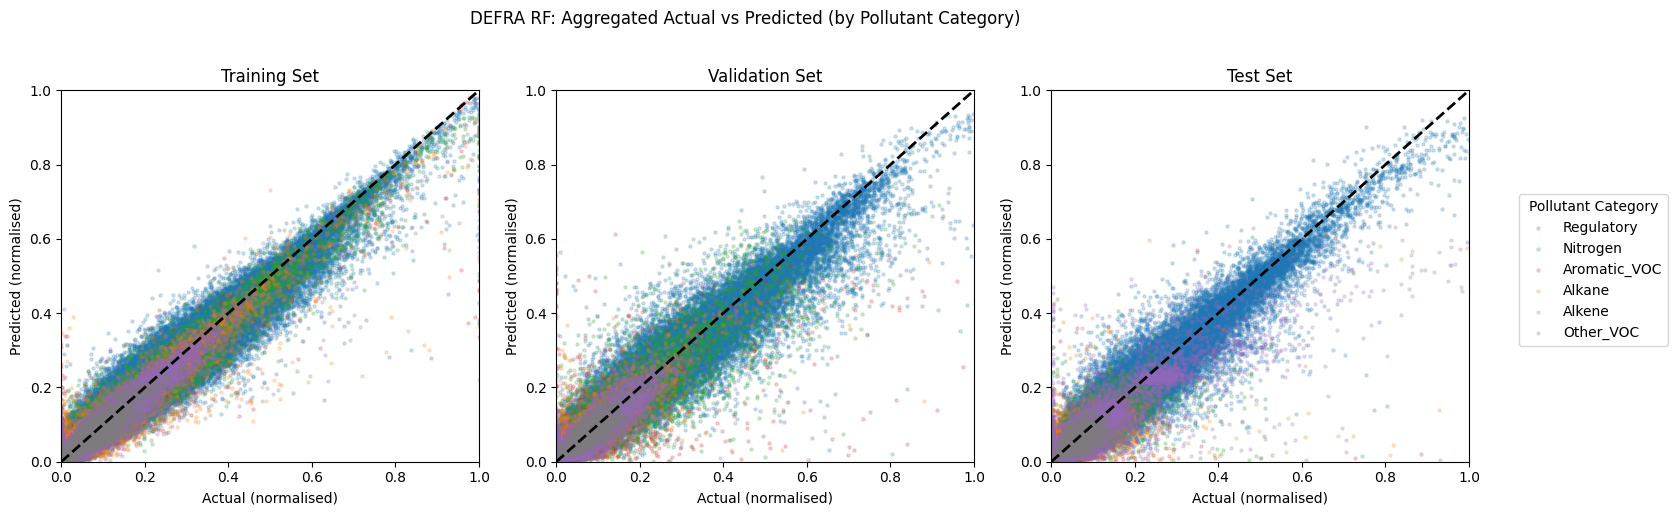

Saved: aggregated_actual_vs_predicted.png


In [45]:
##Aggregated actual vs predicted with colours by pollutant category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Define colours for each pollutant category
category_colors = {
    'Regulatory': '#1f77b4',    # blue
    'Nitrogen': '#2ca02c',      # green
    'Aromatic_VOC': '#d62728',  # red
    'Alkane': '#ff7f0e',        # orange
    'Alkene': '#9467bd',        # purple
    'Other_VOC': '#7f7f7f'      # grey
}

# Collect predictions by category
data_by_category = {cat: {'train_actual': [], 'train_pred': [],
                          'val_actual': [], 'val_pred': [],
                          'test_actual': [], 'test_pred': []} 
                    for cat in category_colors.keys()}

for target in valid_models['target'].values:
    target_idx = target_mapping[target]
    category = get_category(target)
    model = all_models[target]
    
    data_by_category[category]['train_actual'].extend(y_train[:, target_idx])
    data_by_category[category]['train_pred'].extend(model.predict(X_train_rf))
    data_by_category[category]['val_actual'].extend(y_val[:, target_idx])
    data_by_category[category]['val_pred'].extend(model.predict(X_val_rf))
    data_by_category[category]['test_actual'].extend(y_test[:, target_idx])
    data_by_category[category]['test_pred'].extend(model.predict(X_test_rf))

# Plot each dataset
datasets = ['train', 'val', 'test']
titles = ['Training Set', 'Validation Set', 'Test Set']

for ax, dataset, title in zip(axes, datasets, titles):
    # Plot each category
    for category in category_colors.keys():
        actual = data_by_category[category][f'{dataset}_actual']
        pred = data_by_category[category][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, 
                      c=category_colors[category], label=category)
    
    # Perfect prediction line
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Add single legend to the right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), 
           title='Pollutant Category')

plt.suptitle('DEFRA RF: Aggregated Actual vs Predicted (by Pollutant Category)', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'aggregated_actual_vs_predicted.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("Saved: aggregated_actual_vs_predicted.png")

In [47]:
# Define colours for each pollutant category
category_colors = {
    'Regulatory': '#1f77b4',    # blue
    'Nitrogen': '#2ca02c',      # green
    'Aromatic_VOC': '#d62728',  # red
    'Alkane': '#ff7f0e',        # orange
    'Alkene': '#9467bd',        # purple
    'Other_VOC': '#7f7f7f'      # grey
}

# Filter models by r2 thresholds directly from valid_models
all_targets = valid_models['target'].values
excellent_targets = valid_models[valid_models['test_r2'] >= 0.75]['target'].values
good_targets = valid_models[(valid_models['test_r2'] >= 0.65) & (valid_models['test_r2'] < 0.75)]['target'].values
moderate_targets = valid_models[(valid_models['test_r2'] > 0.50) & (valid_models['test_r2'] < 0.65)]['target'].values

print(f"All valid models: {len(all_targets)}")
print(f"Excellent models (r2 >= 0.75): {len(excellent_targets)}")
print(f"Good models (0.65 <= r2 < 0.75): {len(good_targets)}")
print(f"Moderate models (0.50 < r2 < 0.65): {len(moderate_targets)}")

All valid models: 92
Excellent models (r2 >= 0.75): 44
Good models (0.65 <= r2 < 0.75): 8
Moderate models (0.50 < r2 < 0.65): 14


    All valid models: 92
    Excellent models (r2 >= 0.75): 44
    Good models (0.65 <= r2 < 0.75): 8
    Moderate models (0.50 < r2 < 0.65): 14

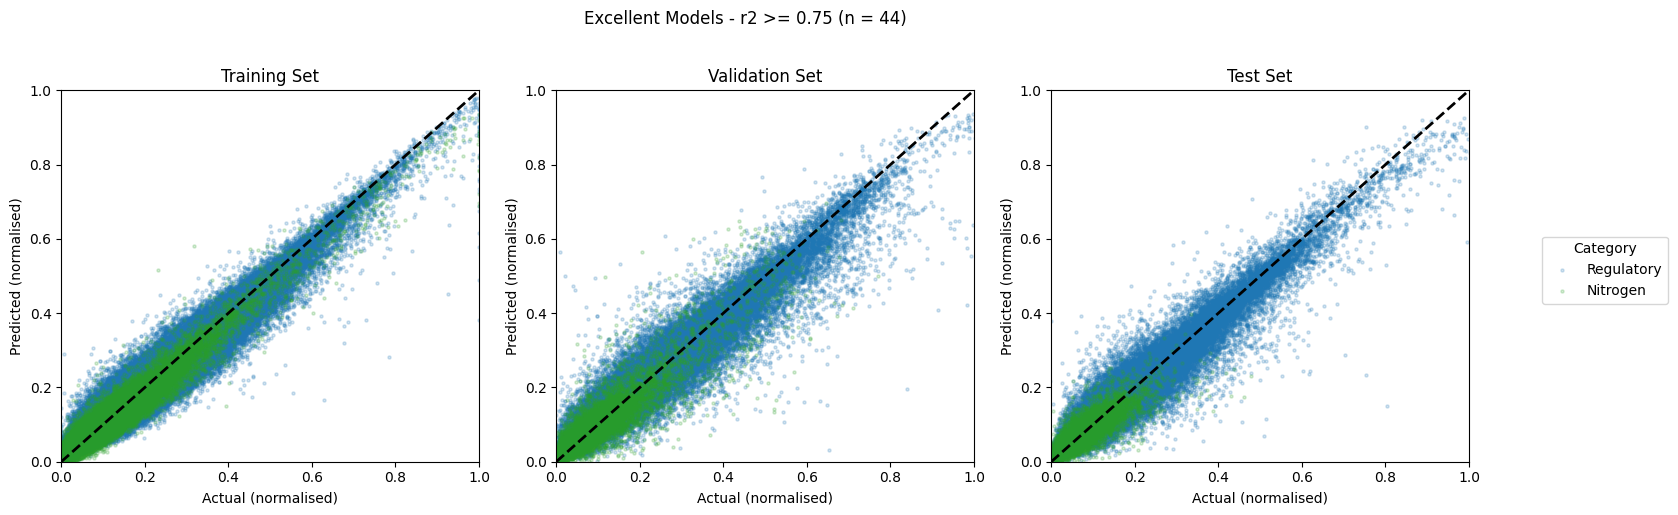

Saved: actual_vs_predicted_excellent.png


In [48]:
# Plot 2 Excellent models (r2 >= 0.75)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

data_excellent = {cat: {'train_actual': [], 'train_pred': [],
                        'val_actual': [], 'val_pred': [],
                        'test_actual': [], 'test_pred': []} 
                  for cat in category_colors.keys()}

for target in excellent_targets:
    target_idx = target_mapping[target]
    category = get_category(target)
    model = all_models[target]
    
    data_excellent[category]['train_actual'].extend(y_train[:, target_idx])
    data_excellent[category]['train_pred'].extend(model.predict(X_train_rf))
    data_excellent[category]['val_actual'].extend(y_val[:, target_idx])
    data_excellent[category]['val_pred'].extend(model.predict(X_val_rf))
    data_excellent[category]['test_actual'].extend(y_test[:, target_idx])
    data_excellent[category]['test_pred'].extend(model.predict(X_test_rf))

for ax, dataset, title in zip(axes, datasets, titles):
    for category in category_colors.keys():
        actual = data_excellent[category][f'{dataset}_actual']
        pred = data_excellent[category][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, 
                      c=category_colors[category], label=category)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

handles, labels = axes[2].get_legend_handles_labels()
if len(handles) > 0:
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), 
               title='Category')

plt.suptitle(f'Excellent Models - r2 >= 0.75 (n = {len(excellent_targets)})', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'actual_vs_predicted_excellent.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("Saved: actual_vs_predicted_excellent.png")

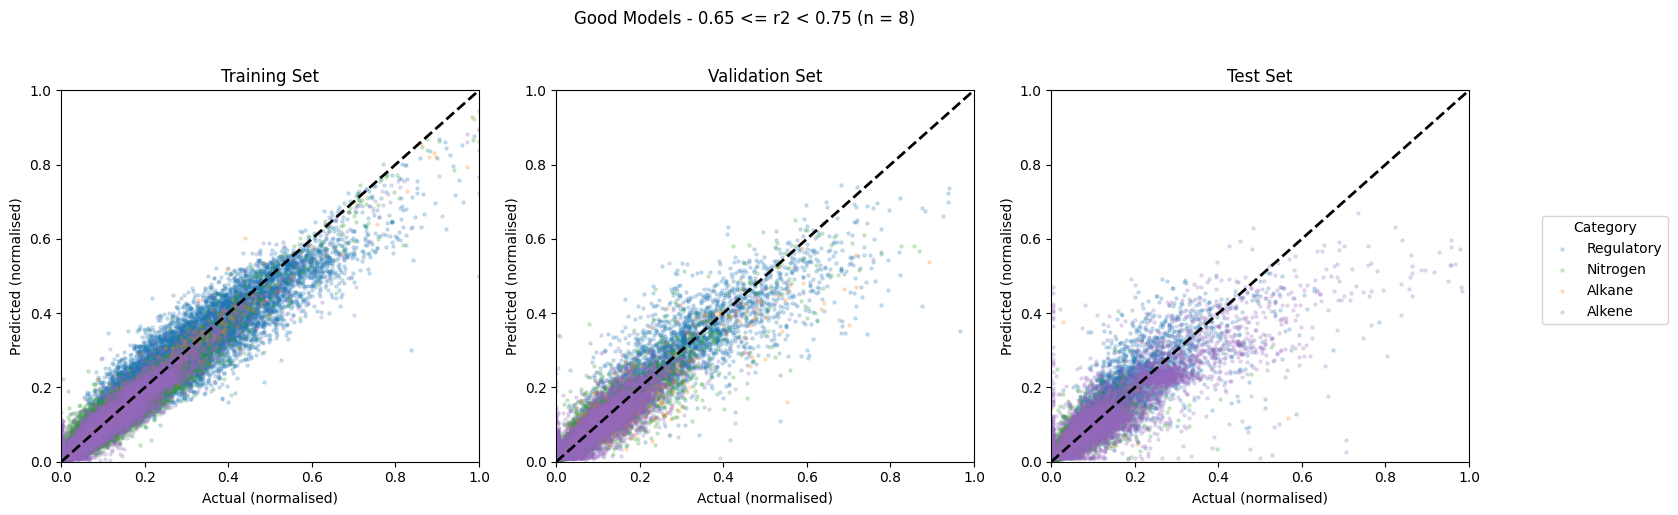

Saved: actual_vs_predicted_good.png


In [49]:

# Plot 3: Good models (0.65 <= r2 < 0.75)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

data_good = {cat: {'train_actual': [], 'train_pred': [],
                   'val_actual': [], 'val_pred': [],
                   'test_actual': [], 'test_pred': []} 
             for cat in category_colors.keys()}

for target in good_targets:
    target_idx = target_mapping[target]
    category = get_category(target)
    model = all_models[target]
    
    data_good[category]['train_actual'].extend(y_train[:, target_idx])
    data_good[category]['train_pred'].extend(model.predict(X_train_rf))
    data_good[category]['val_actual'].extend(y_val[:, target_idx])
    data_good[category]['val_pred'].extend(model.predict(X_val_rf))
    data_good[category]['test_actual'].extend(y_test[:, target_idx])
    data_good[category]['test_pred'].extend(model.predict(X_test_rf))

for ax, dataset, title in zip(axes, datasets, titles):
    for category in category_colors.keys():
        actual = data_good[category][f'{dataset}_actual']
        pred = data_good[category][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, 
                      c=category_colors[category], label=category)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

handles, labels = axes[2].get_legend_handles_labels()
if len(handles) > 0:
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), 
               title='Category')

plt.suptitle(f'Good Models - 0.65 <= r2 < 0.75 (n = {len(good_targets)})', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'actual_vs_predicted_good.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("Saved: actual_vs_predicted_good.png")

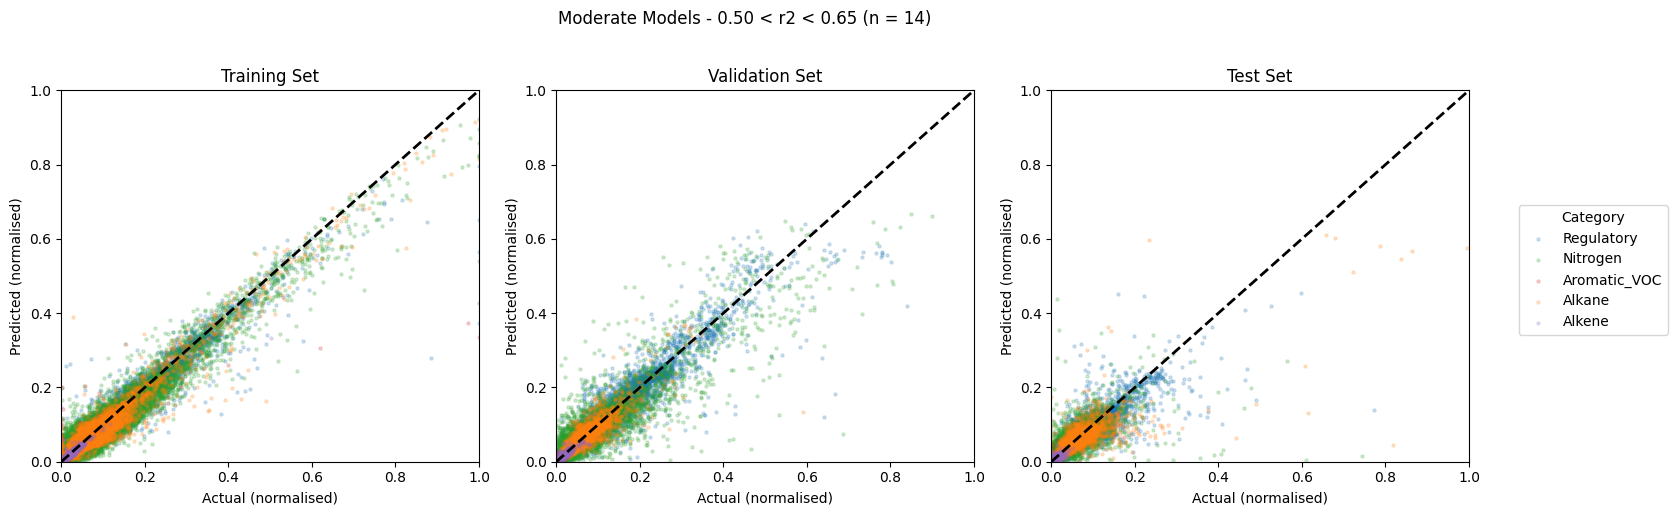

Saved: actual_vs_predicted_moderate.png


In [50]:
# Plot 4: Moderate models (0.50 < r2 < 0.65)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

data_moderate = {cat: {'train_actual': [], 'train_pred': [],
                       'val_actual': [], 'val_pred': [],
                       'test_actual': [], 'test_pred': []} 
                 for cat in category_colors.keys()}

for target in moderate_targets:
    target_idx = target_mapping[target]
    category = get_category(target)
    model = all_models[target]
    
    data_moderate[category]['train_actual'].extend(y_train[:, target_idx])
    data_moderate[category]['train_pred'].extend(model.predict(X_train_rf))
    data_moderate[category]['val_actual'].extend(y_val[:, target_idx])
    data_moderate[category]['val_pred'].extend(model.predict(X_val_rf))
    data_moderate[category]['test_actual'].extend(y_test[:, target_idx])
    data_moderate[category]['test_pred'].extend(model.predict(X_test_rf))

for ax, dataset, title in zip(axes, datasets, titles):
    for category in category_colors.keys():
        actual = data_moderate[category][f'{dataset}_actual']
        pred = data_moderate[category][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, 
                      c=category_colors[category], label=category)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

handles, labels = axes[2].get_legend_handles_labels()
if len(handles) > 0:
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), 
               title='Category')

plt.suptitle(f'Moderate Models - 0.50 < r2 < 0.65 (n = {len(moderate_targets)})', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'actual_vs_predicted_moderate.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("Saved: actual_vs_predicted_moderate.png")

### Performance Categories by r² Threshold

The scatter plots separate models into performance categories based on Gilik, A., Ogrenci, A.S. and Ozmen, A. (2021) ‘Air quality prediction using CNN+LSTM-based hybrid deep learning architecture’ benchmarks. Each point represents one hourly prediction, coloured by pollutant category.

**Colour legend:**

- Blue: Regulatory (NO2, PM10, PM25, O3, SO2, CO).
- Green: Nitrogen (NO, NOx).
- Red: Aromatic_VOC (Benzene, Toluene, Xylenes, TMBs).
- Orange: Alkane (Ethane, Propane, Butanes, Pentanes, Hexanes, Heptane, Octanes).
- Purple: Alkene (Ethene, Propene, Butenes, Pentenes, Butadiene, Isoprene).
- Grey: Other_VOC (Ethyne).

---

**Excellent Models (r² ≥ 0.75) — n = 44 models:**

*Training set:*

- Very tight clustering around the diagonal for both categories.
- Regulatory (blue) dominates with dense coverage across full value range.
- Nitrogen (green) shows equally tight fit, concentrated in lower-mid range (0.0–0.5).

*Validation set:*

- Slight increase in scatter compared to training, but still well-constrained.
- Both categories maintain strong alignment with perfect prediction line.
- No visible systematic bias.

*Test set:*

- Consistent performance with validation set.
- Regulatory pollutants show excellent generalisation across full range.
- Nitrogen species maintain tight clustering despite lower concentration range.
- Minimal underestimation at peak values compared to other categories.

*Key observation:* Only Regulatory and Nitrogen categories achieve excellent performance. This reflects the strong temporal autocorrelation and predictable diurnal/weekly patterns in these pollutants.

---

**Good Models (0.65 ≤ r² < 0.75) — n = 8 models:**

*Training set:*

- Four categories present: Regulatory, Nitrogen, Alkane, Alkene.
- Wider scatter than excellent models, especially at mid-range values.
- Alkene (purple) shows distinct clustering pattern at lower concentrations.
- Alkane (orange) visible but sparse.

*Validation set:*

- Noticeable increase in scatter for all categories.
- Regulatory (blue) shows some outliers at higher values.
- Alkene (purple) maintains relatively consistent spread.

*Test set:*

- Similar pattern to validation.
- More scatter at mid-range values (0.2–0.5 actual).
- Underestimation becomes visible at higher values for Regulatory.
- Alkene predictions cluster in narrow range, reflecting limited concentration variability.

*Key observation:* This transitional category includes remaining Regulatory pollutants (likely PM10, some NO2) plus biogenic Alkenes (Isoprene) and stable Alkanes (Ethane). These compounds have more complex source patterns or shorter atmospheric lifetimes.

---

**Moderate Models (0.50 < r² < 0.65) — n = 14 models:**

*Training set:*

- Five categories present, indicating diverse compound types.
- Much wider scatter than higher categories.
- Aromatic_VOC (red) appears, clustered at very low concentrations (0.0–0.15).
- Alkane (orange) shows distinct horizontal banding pattern.
- Nitrogen (green) dominates mid-range with noticeable spread.

*Validation set:*

- Substantial scatter increase.
- Clear horizontal banding for Alkanes suggests mean reversion prediction.
- Aromatic_VOCs remain constrained to low-value corner.
- Regulatory outliers visible at extreme values.

*Test set:*

- Pronounced scatter across all categories.
- Aromatic_VOCs (red) show systematic overestimation (points above diagonal).
- Alkanes show characteristic "regression to mean" pattern.
- Nitrogen species show highest scatter in this category.
- Limited prediction range: most predictions fall between 0.1–0.3 regardless of actual values.

*Key observation:* Moderate models struggle with VOCs from single-station data (Marylebone Road). The horizontal banding indicates models default to predicting mean values when true patterns cannot be learned.

---

**Summary by Category:**

| Category     | Excellent | Good | Moderate | Total Valid | Interpretation                                    |
| ------------ | --------- | ---- | -------- | ----------- | ------------------------------------------------- |
| Regulatory   | 38        | 3    | 1        | 42          | Highly predictable; strong temporal patterns.     |
| Nitrogen     | 6         | 1    | 5        | 12          | NO more variable than NOx due to O3 reaction.     |
| Alkene       | 0         | 2    | 2        | 4           | Isoprene predictable; traffic alkenes less so.    |
| Alkane       | 0         | 2    | 3        | 5           | Ethane stable; heavier alkanes highly variable.   |
| Aromatic_VOC | 0         | 0    | 3        | 3           | Single-station limitation; need spatial coverage. |
| Other_VOC    | 0         | 0    | 0        | 0           | All excluded (Ethyne r² < 0.50).                  |

**Key findings:**

1. **Category determines performance ceiling:** Regulatory pollutants achieve excellent results (r² ≥ 0.75) while VOCs from single stations rarely exceed moderate (r² < 0.65).

2. **Scatter pattern reveals model behaviour:** Excellent models show tight diagonal clustering; moderate models show horizontal banding indicating mean-reversion when patterns unlearnable.

3. **Generalisation gap increases with category:** Excellent models show minimal train-to-test degradation; moderate models show substantial scatter increase.

4. **VOC limitation is data-driven, not methodological:** The 14 moderate and 26 excluded models predominantly come from Marylebone Road single-station VOC monitoring, where spatial representativeness limits predictability.

Models for visualisation: 83 (excluding 9 with R² < 0)


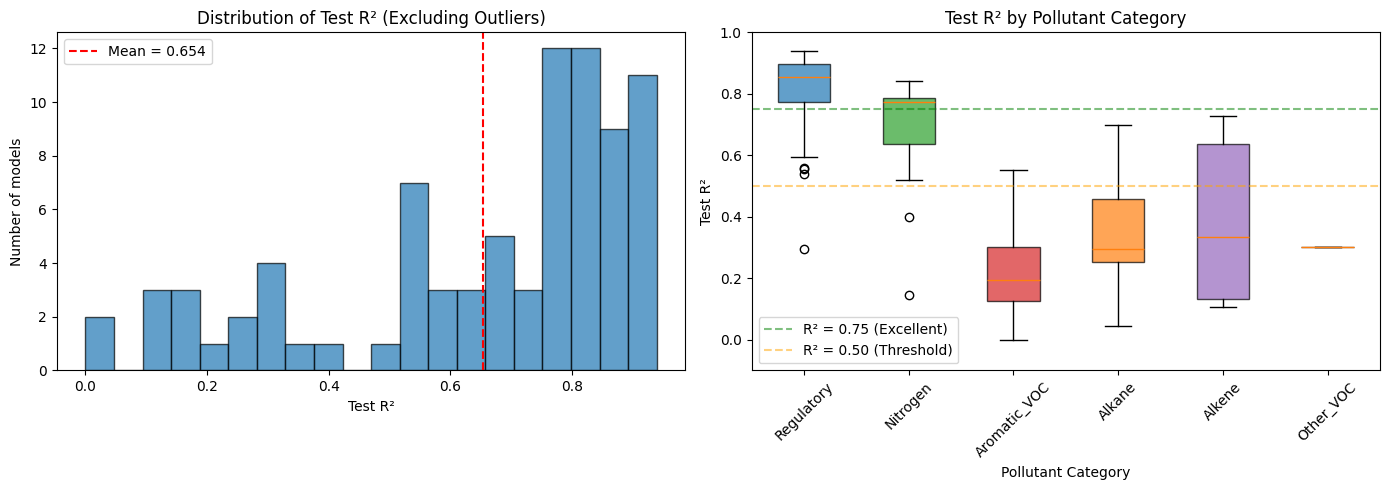

Saved: r2_distribution_by_category.png


In [54]:
# Using valid_models (excluding broken models)
valid_for_plot = valid_models[valid_models['test_r2'] >= 0].copy()

print(f"Models for visualisation: {len(valid_for_plot)} (excluding {len(valid_models) - len(valid_for_plot)} with R² < 0)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(valid_for_plot['test_r2'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(valid_for_plot['test_r2'].mean(), color='red', linestyle='--', 
                label=f"Mean = {valid_for_plot['test_r2'].mean():.3f}")
axes[0].set_xlabel('Test R²')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of Test R² (Excluding Outliers)')
axes[0].legend()

# Boxplot by pollutant category
category_order = ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']
category_colors_list = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e', '#9467bd', '#7f7f7f']

# Add category column if not present
if 'category' not in valid_for_plot.columns:
    valid_for_plot['category'] = valid_for_plot['target'].apply(get_category)

box_data = [valid_for_plot[valid_for_plot['category'] == cat]['test_r2'].values 
            for cat in category_order if cat in valid_for_plot['category'].values]
box_labels = [cat for cat in category_order if cat in valid_for_plot['category'].values]
box_colors = [category_colors_list[category_order.index(cat)] for cat in box_labels]

bp = axes[1].boxplot(box_data, tick_labels=box_labels, patch_artist=True)

# Colour each box by category
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_xlabel('Pollutant Category')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² by Pollutant Category')
axes[1].axhline(0.75, color='green', linestyle='--', alpha=0.5, label='R² = 0.75 (Excellent)')
axes[1].axhline(0.50, color='orange', linestyle='--', alpha=0.5, label='R² = 0.50 (Threshold)')
axes[1].set_ylim(-0.1, 1)
axes[1].legend(loc='lower left')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(rf_output_dir / 'r2_distribution_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: r2_distribution_by_category.png")

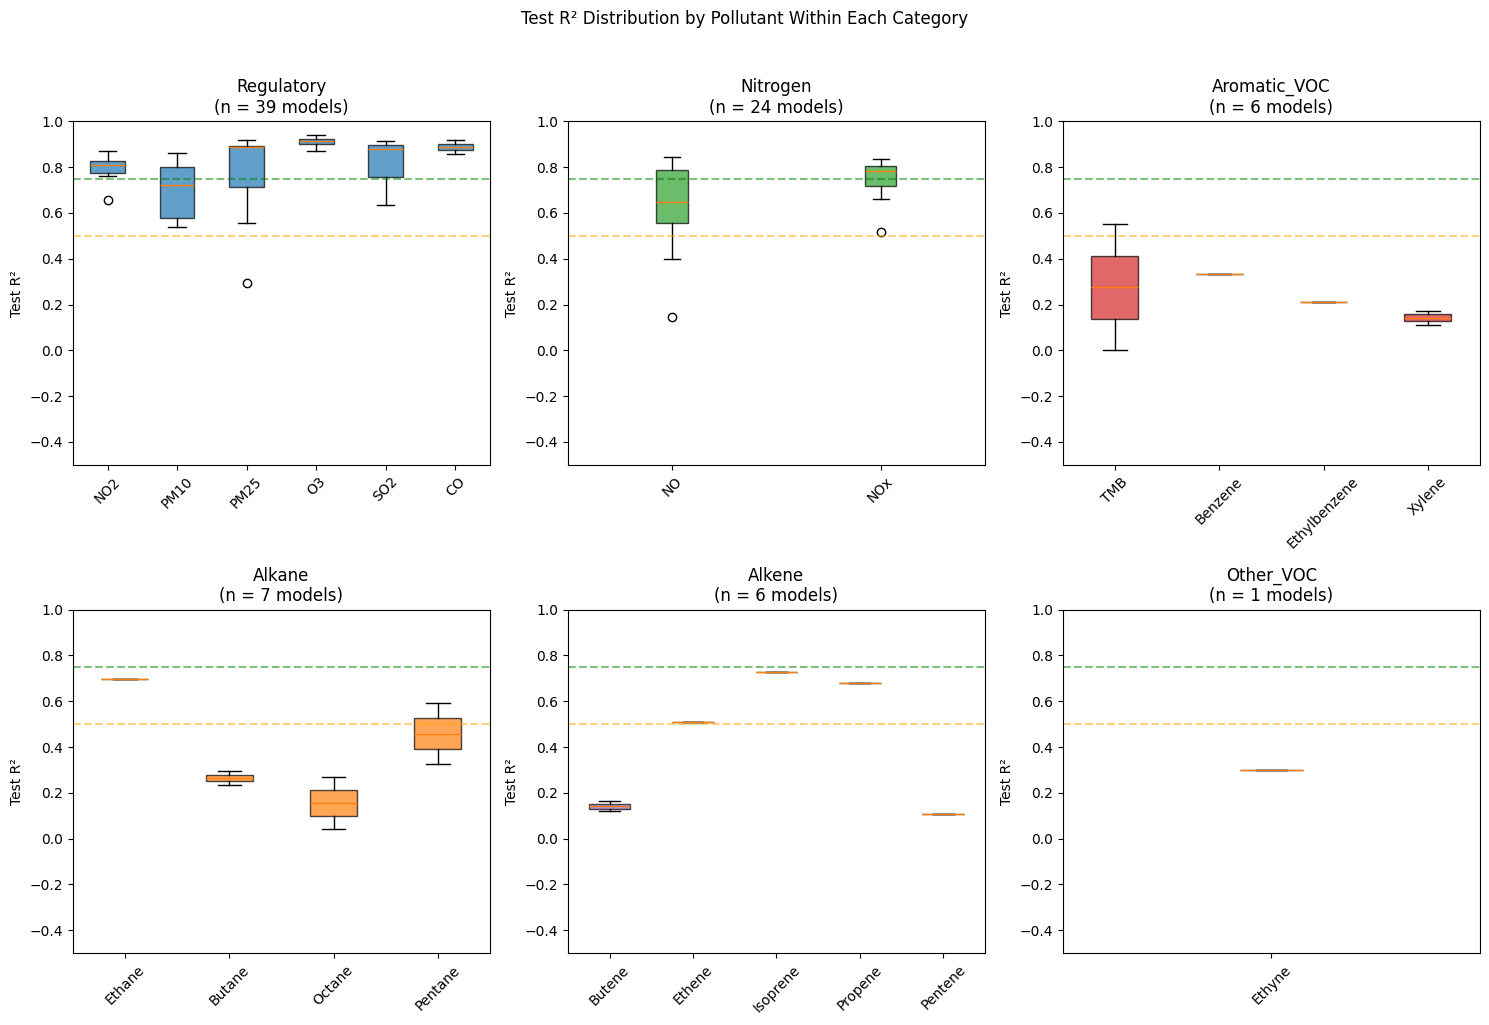

Saved: r2_distribution_by_pollutant_within_category.png


In [55]:
# Create figure with subplots for each category
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

category_order = ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']
category_colors_list = ['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e', '#9467bd', '#7f7f7f']

for idx, (cat, color) in enumerate(zip(category_order, category_colors_list)):
    ax = axes[idx]
    
    #Filter data for this category
    cat_data = valid_for_plot[valid_for_plot['category'] == cat]
    
    if len(cat_data) == 0:
        ax.text(0.5, 0.5, 'No valid models', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{cat}\n(n = 0)')
        continue
    
    #Get unique pollutants in this category
    pollutants = cat_data['target'].apply(get_pollutant).unique()
    
    box_data = [cat_data[cat_data['target'].apply(get_pollutant) == poll]['test_r2'].values 
                for poll in pollutants]
    
    bp = ax.boxplot(box_data, tick_labels=pollutants, patch_artist=True)
    
    #Colour all boxes with category colour
    for patch in bp['boxes']:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.axhline(0.75, color='green', linestyle='--', alpha=0.5)
    ax.axhline(0.50, color='orange', linestyle='--', alpha=0.5)
    ax.set_ylim(-0.5, 1)
    ax.set_ylabel('Test R²')
    ax.set_title(f'{cat}\n(n = {len(cat_data)} models)')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Test R² Distribution by Pollutant Within Each Category', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'r2_distribution_pollutant_category.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: r2_distribution_by_pollutant_within_category.png")

Time series plots for best model per pollutant category


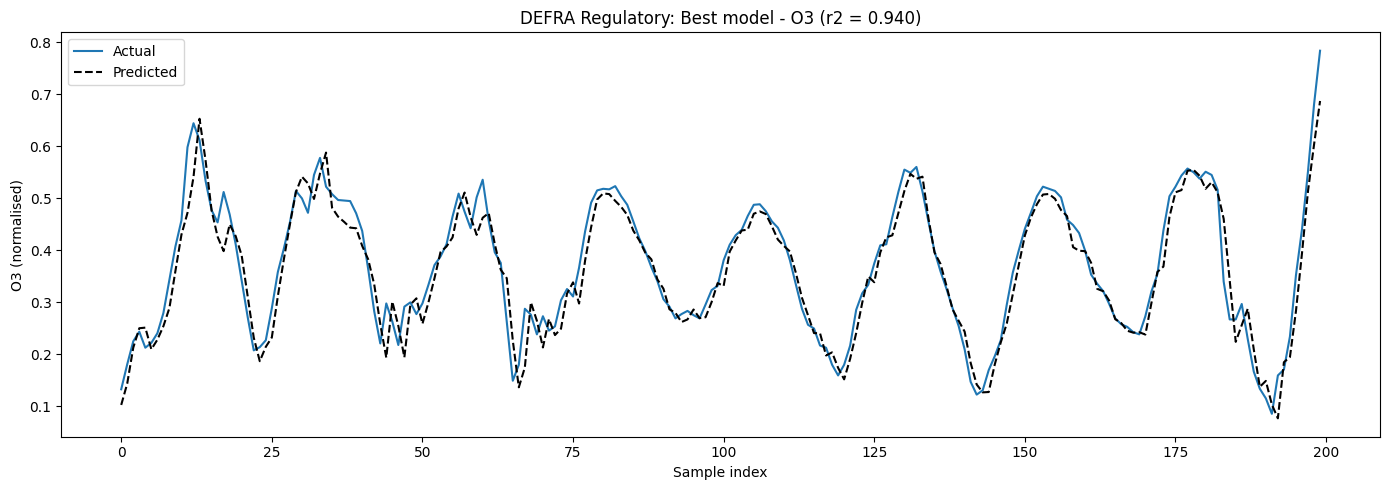

Regulatory: London_Haringey_Priory_Park_South_O3 (r2 = 0.9395)
--------------------------------------------------


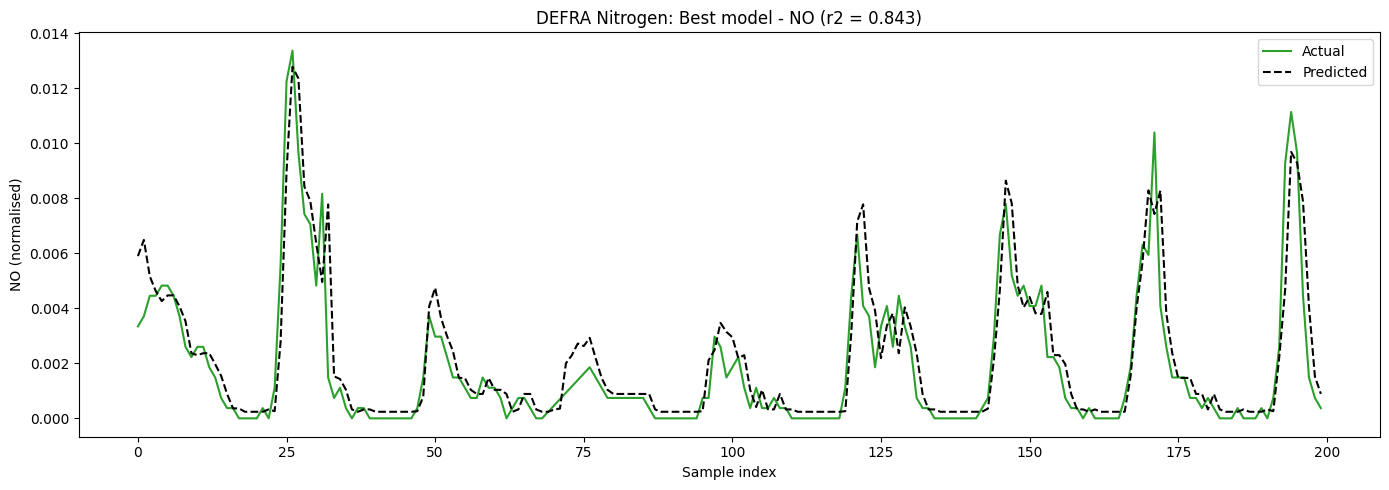

Nitrogen: London_N._Kensington_NO (r2 = 0.8426)
--------------------------------------------------


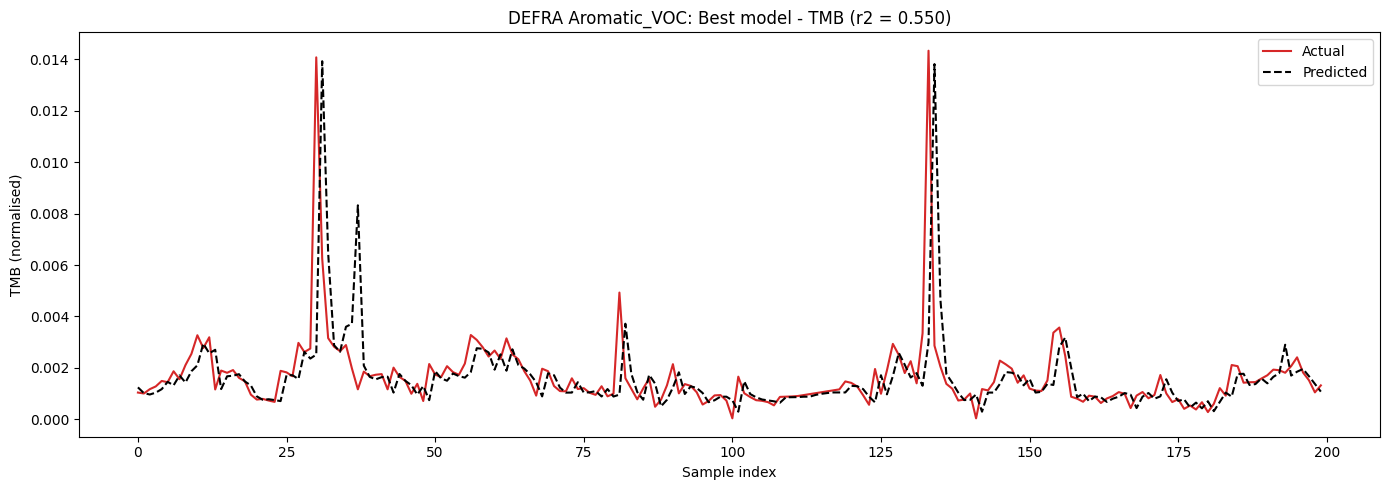

Aromatic_VOC: London_Marylebone_Road_1_2_4_TMB (r2 = 0.5505)
--------------------------------------------------


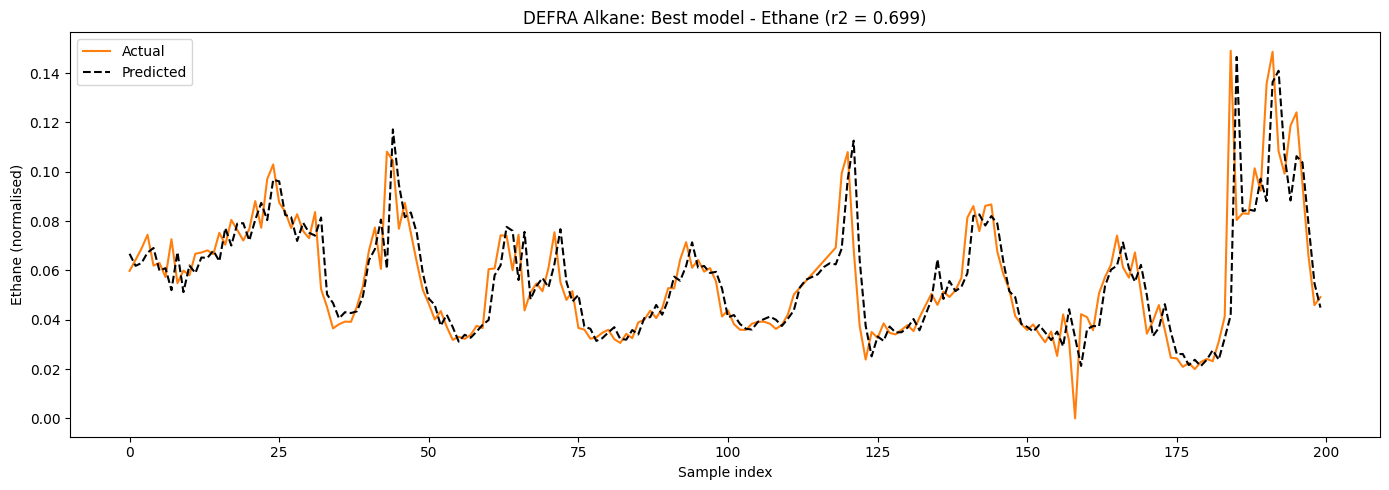

Alkane: London_Marylebone_Road_Ethane (r2 = 0.6985)
--------------------------------------------------


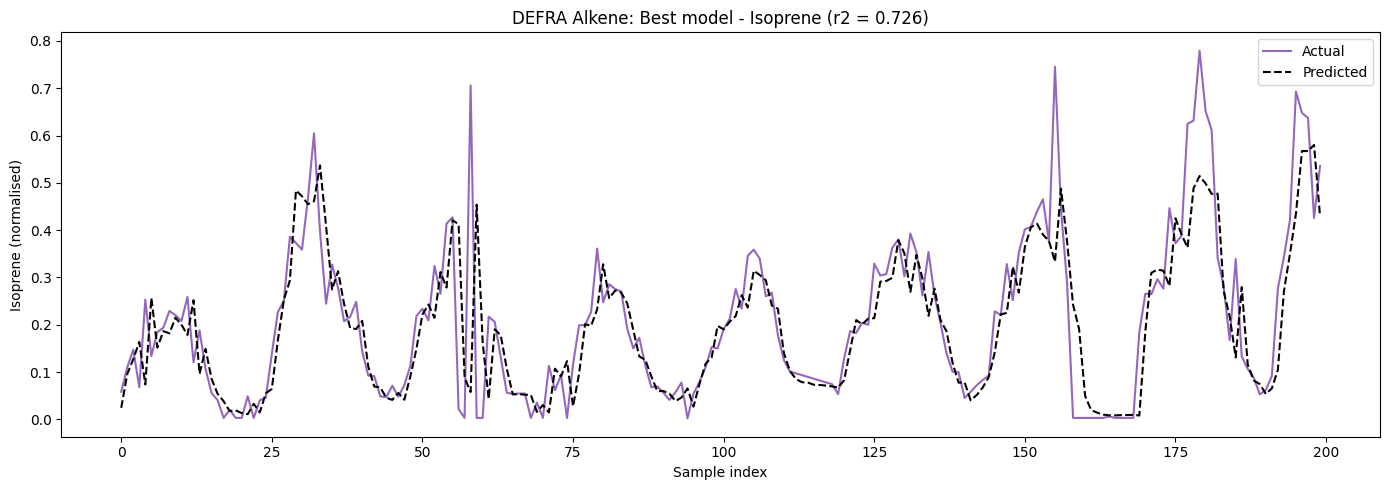

Alkene: London_Marylebone_Road_Isoprene (r2 = 0.7263)
--------------------------------------------------


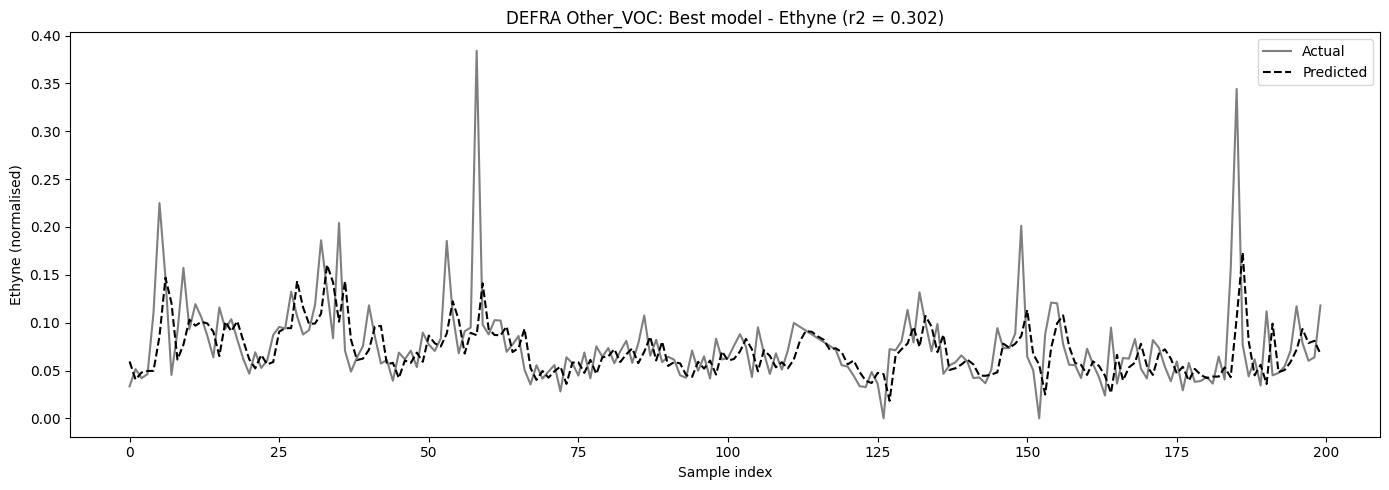

Other_VOC: London_Marylebone_Road_Ethyne (r2 = 0.3018)
--------------------------------------------------

All time series plots saved.


In [56]:
#Time-series plots for best model of each pollutant category
category_colors = {
    'Regulatory': '#1f77b4',    #blue
    'Nitrogen': '#2ca02c',      #green
    'Aromatic_VOC': '#d62728',  #red
    'Alkane': '#ff7f0e',        #orange
    'Alkene': '#9467bd',        #purple
    'Other_VOC': '#7f7f7f'      #grey
}

n_samples = 200

#Add category column if not present
if 'category' not in valid_models.columns:
    valid_models['category'] = valid_models['target'].apply(get_category)

print("Time series plots for best model per pollutant category")
print("=" * 40)

for category in ['Regulatory', 'Nitrogen', 'Aromatic_VOC', 'Alkane', 'Alkene', 'Other_VOC']:
    #Find best model for this category
    cat_results = valid_models[valid_models['category'] == category]
    
    if len(cat_results) == 0:
        print(f"{category}: No valid models")
        continue
    
    best_target = cat_results.loc[cat_results['test_r2'].idxmax(), 'target']
    best_r2 = cat_results['test_r2'].max()
    best_pollutant = get_pollutant(best_target)
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    #Get predictions
    y_pred_test = model.predict(X_test_rf)
    y_actual_test = y_test[:, target_idx]
    
    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(range(n_samples), y_actual_test[:n_samples], 
            label='Actual', color=category_colors[category], linewidth=1.5)
    ax.plot(range(n_samples), y_pred_test[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_pollutant} (normalised)')
    ax.set_title(f'DEFRA {category}: Best model - {best_pollutant} (r2 = {best_r2:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(rf_output_dir / f'time_series_{category}_{best_pollutant}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"{category}: {best_target} (r2 = {best_r2:.4f})")
    print("-" * 50)

print("\nAll time series plots saved.")

### Time Series Analysis by Pollutant Category

**Best performing model per category:**

| Category     | Best Model                           | Pollutant | r²    | Performance |
| ------------ | ------------------------------------ | --------- | ----- | ----------- |
| Regulatory   | London_Haringey_Priory_Park_South_O3 | O3        | 0.940 | Excellent   |
| Nitrogen     | London_N._Kensington_NO              | NO        | 0.843 | Excellent   |
| Alkene       | London_Marylebone_Road_Isoprene      | Isoprene  | 0.726 | Good        |
| Alkane       | London_Marylebone_Road_Ethane        | Ethane    | 0.699 | Good        |
| Aromatic_VOC | London_Marylebone_Road_1_2_4_TMB     | TMB       | 0.550 | Moderate    |
| Other_VOC    | London_Marylebone_Road_Ethyne        | Ethyne    | 0.302 | Excluded    |

---

### DEFRA Regulatory vs LAQN Comparison

| Pollutant | DEFRA Best Model                     | DEFRA r² | LAQN Best Model | LAQN r² | Better  |
| --------- | ------------------------------------ | -------- | --------------- | ------- | ------- |
| O3        | London_Haringey_Priory_Park_South_O3 | 0.940    | HG4_O3          | 0.939   | Similar |
| PM25      | Borehamwood_Meadow_Park_PM25         | 0.920    | HP1_PM25        | 0.899   | DEFRA   |
| CO        | London_N._Kensington_CO              | 0.916    | KC1_CO          | 0.823   | DEFRA   |
| SO2       | London_Bloomsbury_SO2                | 0.906    | BG1_SO2         | 0.915   | Similar |
| NO2       | Haringey_Roadside_NO2                | 0.865    | TH2_NO2         | 0.878   | LAQN    |
| PM10      | Borehamwood_Meadow_Park_PM10         | 0.861    | CW3_PM10        | 0.854   | Similar |

---

### Time Series Pattern Observations

**Regulatory (O3, r² = 0.940):**

- Clear diurnal cycling with ~24-hour periodicity visible in plot.
- Predictions track actual values with minimal lag.
- Peak values (0.6–0.8 normalised) captured accurately.
- Photochemical formation provides highly predictable patterns.

**Nitrogen (NO, r² = 0.843):**

- Spiky pattern with sharp peaks reflecting traffic emissions.
- Low baseline (near zero) with episodic spikes to 0.012–0.014.
- Model captures spike timing but slightly underestimates peak magnitude.
- Rapid NO-O3 reaction creates challenging prediction targets.

**Alkene (Isoprene, r² = 0.726):**

- Strong diurnal pattern driven by temperature and sunlight.
- Biogenic emissions create predictable daytime peaks.
- More variable than regulatory pollutants due to vegetation response.
- Model captures overall pattern but misses some rapid fluctuations.

**Alkane (Ethane, r² = 0.699):**

- Moderate variability with less pronounced cycling.
- Natural gas leakage provides relatively stable baseline.
- Peaks correspond to heating/cooking activity periods.
- Single-station limitation reduces spatial representativeness.

**Aromatic_VOC (TMB, r² = 0.550):**

- Highly episodic with extreme spikes (0.014) above low baseline.
- Model captures major events but misses smaller variations.
- Traffic and solvent sources create unpredictable patterns.
- Single Marylebone Road station limits predictability.

**Other_VOC (Ethyne, r² = 0.302):**

- Poor model performance, excluded from useful models.
- Combustion source highly variable and localised.
- Single-station data insufficient for reliable prediction.
- Would require multi-station network for improvement.

---

### Key Findings

**Category performance hierarchy:**

1. **Regulatory pollutants** achieve excellent results (r² = 0.86–0.94) due to well-understood atmospheric chemistry, multiple monitoring stations, and predictable temporal patterns.

2. **Nitrogen species** perform well (r² = 0.84) despite rapid atmospheric reactions, benefiting from strong traffic-related diurnal cycles.

3. **Biogenic VOCs** (Isoprene) show good predictability (r² = 0.73) due to temperature/light-driven emissions following predictable patterns.

4. **Stable alkanes** (Ethane) achieve moderate-good performance (r² = 0.70) from consistent natural gas sources.

5. **Traffic VOCs** (Aromatics, Ethyne) struggle (r² < 0.55) due to highly localised, episodic emissions and single-station limitation.

**DEFRA vs LAQN comparison:**

- DEFRA outperforms LAQN for CO (0.916 vs 0.823) and PM25 (0.920 vs 0.899).
- LAQN slightly better for NO2 (0.878 vs 0.865) due to denser station network.
- O3, SO2, PM10 show similar performance across both networks.
- DEFRA's higher data quality (91.2% completeness) provides advantage for most pollutants.

**Single-station VOC limitation:**

All VOC measurements come from London Marylebone Road, a single kerbside station. This fundamentally limits model performance because:

- No spatial averaging to smooth local anomalies.
- Kerbside location captures extreme traffic events.
- VOC atmospheric lifetimes (minutes to hours) prevent regional representation.
- Multi-station networks would be required for robust VOC prediction.

**Conclusion:**

Regulatory pollutants and nitrogen species are highly predictable using Random Forest with 12-hour temporal features. VOC prediction requires expanded monitoring networks beyond single-station coverage. DEFRA's superior data quality translates to better performance for most regulatory pollutants compared to LAQN.